In [70]:
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact

from sqlalchemy import create_engine, inspect, text
import os

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd


#Modelagem Estátistica

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from sklearn.preprocessing import MinMaxScaler


#Métricas

from sklearn.metrics import mean_absolute_error, mean_squared_error

In [71]:
engine = create_engine(os.environ["REDSHIFT_READ_URI"], echo=False)

def sql_df(query):
  with engine.connect() as conexao:
    consulta = conexao.execute(text(query))
    dados = consulta.fetchall()
  df = pd.DataFrame(dados, columns= consulta.keys())
  return df

In [72]:
sns.set()

# CASH

In [73]:
query_tx_pagamento = ''' 
select
payment.due_date::date dia, 
sum(value)::float vencimentos_volume,
sum(case when payment.status = 'PAYED' then value end)::float pagamentos_volume,
case when sum(case when payment.status = 'PAYED' then value end) = 0 or sum(value) = 0 then 0 else
sum(case when payment.status = 'PAYED' then value end)/sum(value)::float end as tx_pagamento_volume
from quiteja_lake.payment
left join quiteja_dados.ajuste_payment ap on ap.deal_id = payment.deal_id and ap.installment_number = payment.installment_number  
join kpi.credores on credores.creditor_id = payment.creditor_id
join quiteja_lake.deal on deal.id = payment.deal_id
left join quiteja_lake.operation o on payment.deal_id = o.id and o.active is true 
where 1=1
and "quiteja_lake"."payment"."creditor_id" = 10
and CAST("quiteja_lake"."payment"."due_date" AS date) BETWEEN date '2024-01-01'
   AND date '2024-12-31'
and (ap.new_status in ('EXPIRED','PENDING') or (ap.new_status is null and payment.status not in ('DISCARTED')))
and payment.type = 'DOWN_PAYMENT'
and date(payment.due_date) < current_date
group by 1 
order by 1


'''

In [75]:
tx_pagamento = sql_df(query_tx_pagamento)
tx_pagamento['dia'] = pd.to_datetime(tx_pagamento['dia'])
tx_pagamento['dia_mes'] = tx_pagamento['dia'].dt.day
tx_pagamento = tx_pagamento.set_index(tx_pagamento['dia'])

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe3 in position 127: invalid continuation byte

<Axes: xlabel='dia'>

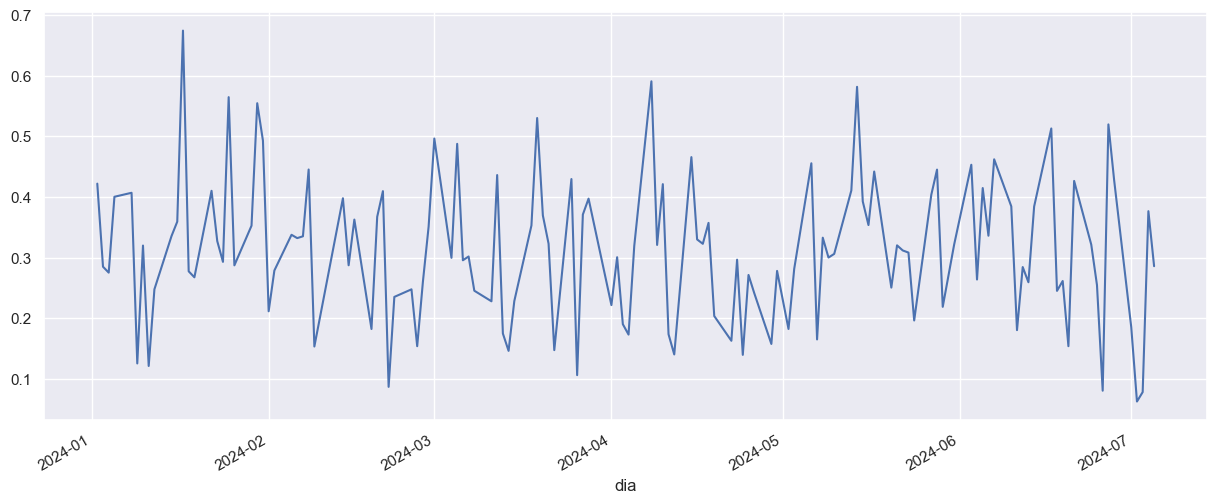

In [ ]:
plt.figure(figsize=(15,6))
tx_pagamento['tx_pagamento_volume'].plot()

<Axes: xlabel='dia'>

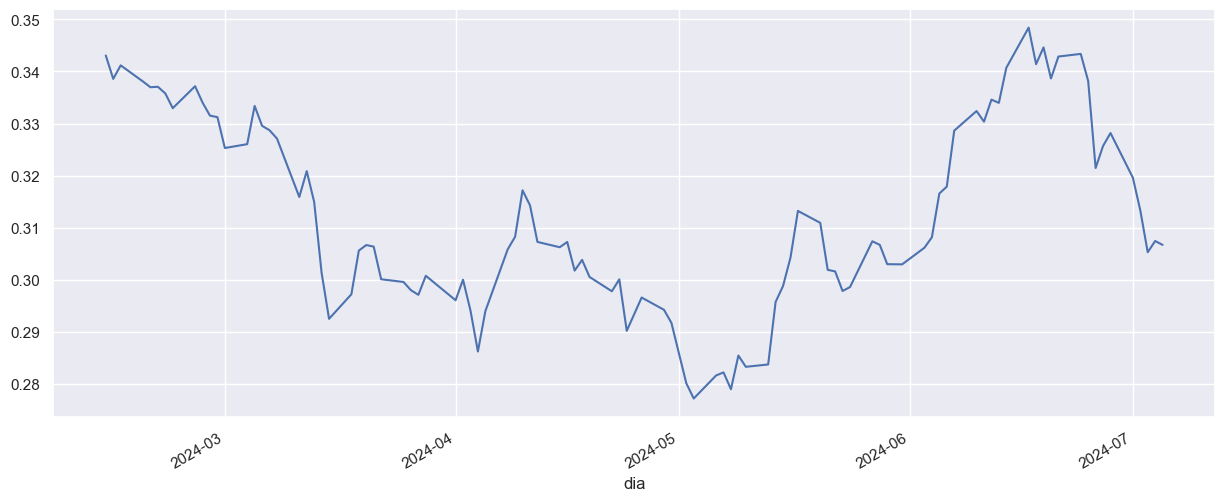

In [ ]:
tx_pagamento['tx_pagamento_volume'].rolling(30).mean().plot(figsize=(15,6))

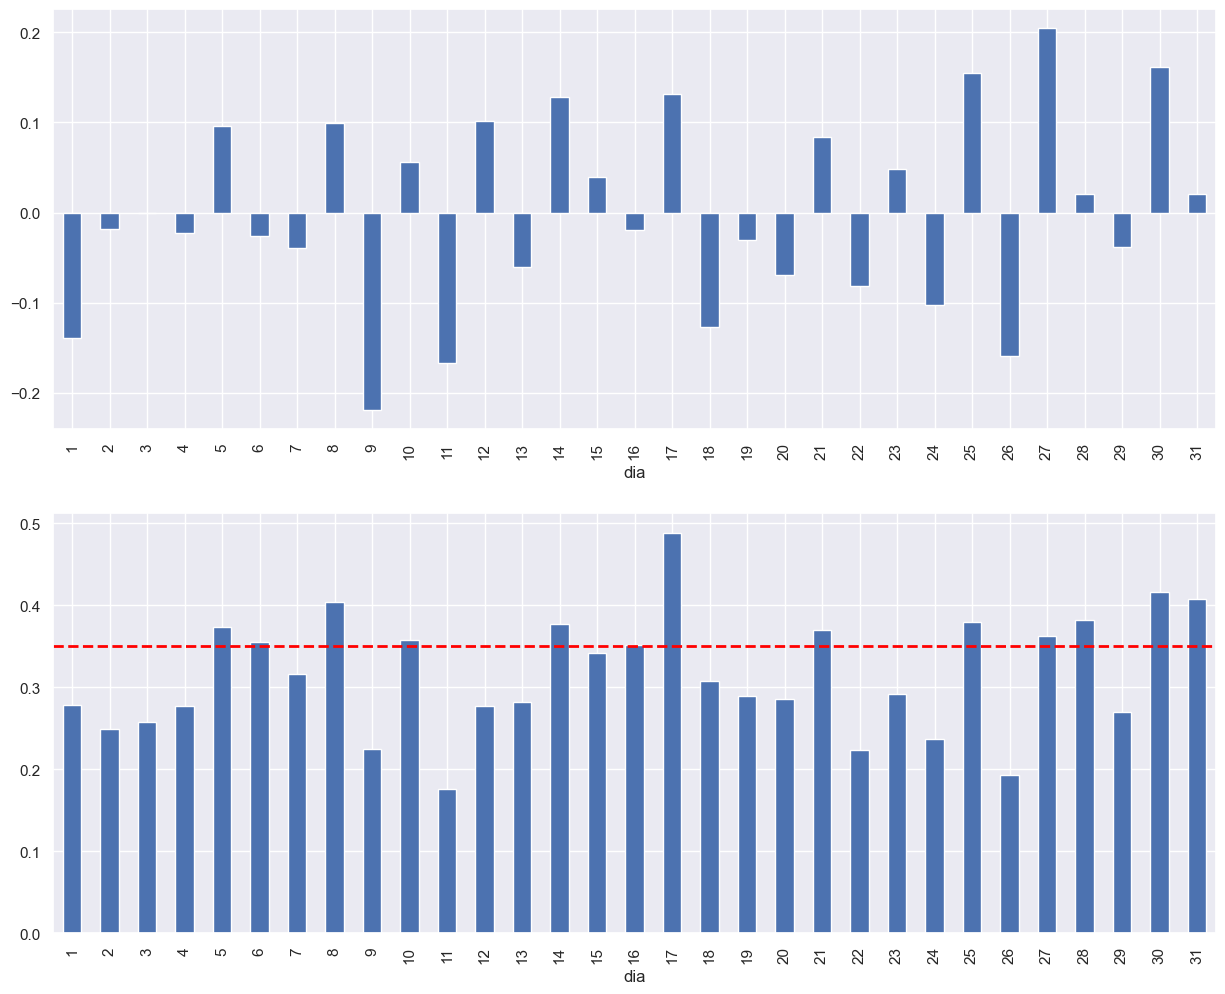

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15,12))
tx_pagamento['tx_pagamento_volume'].diff().groupby(tx_pagamento.index.day).mean().plot(kind='bar', ax=axs[0])
tx_pagamento['tx_pagamento_volume'].groupby(tx_pagamento.index.day).mean().plot(kind='bar',ax=axs[1])
plt.axhline(0.35, color='red', linestyle='--', linewidth=2)

In [ ]:
# Top 10 dias com maior taxa de pagamento 

tx_pagamento['tx_pagamento_volume'].groupby(tx_pagamento.index.day).mean().sort_values(ascending = False).head(10)

dia
17    0.487979
30    0.416311
31    0.407199
8     0.404216
28    0.382609
25    0.380056
14    0.377477
5     0.374218
21    0.369772
27    0.362072
Name: tx_pagamento_volume, dtype: float64

In [ ]:
query_faixa_atraso = ''' 
select
payment.due_date::date dia, 
dim.cod_cluster,
coalesce(dim.de,0) || ' - ' || coalesce(dim.ate,999999) faixa_atraso,
sum(value)::float vencimentos_volume,
sum(case when payment.status = 'PAYED' then value end)::float pagamentos_volume,
case when sum(case when payment.status = 'PAYED' then value end) = 0 or sum(value) = 0 then 0 else
sum(case when payment.status = 'PAYED' then value end)/sum(value)::float end as tx_pagamento_volume
from quiteja_lake.payment
left join quiteja_dados.ajuste_payment ap on ap.deal_id = payment.deal_id and ap.installment_number = payment.installment_number  
join kpi.credores on credores.creditor_id = payment.creditor_id
join quiteja_lake.deal on deal.id = payment.deal_id
left join quiteja_lake.operation o on payment.deal_id = o.id and o.active is true 
join quiteja_dados.dimensoes dim on o.days_of_delay between coalesce(dim.de,0) and coalesce(dim.ate, 999999) and dim.creditor_id = 10 and tipo_cluster = 'Atraso'
where 1=1
and "quiteja_lake"."payment"."creditor_id" = 10
and CAST("quiteja_lake"."payment"."due_date" AS date) BETWEEN date '2024-01-01'
   AND date '2024-12-31'
and (ap.new_status in ('EXPIRED','PENDING') or (ap.new_status is null and payment.status not in ('DISCARTED')))
and payment.type = 'DOWN_PAYMENT'
and date(payment.due_date) < current_date
group by 1, 2, 3 
order by 1, 2 

'''


query_FA_filtred = ''' 
select
payment.due_date::date dia, 
dim.cod_cluster,
coalesce(dim.de,0) || ' - ' || coalesce(dim.ate,999999) faixa_atraso,
sum(value)::float vencimentos_volume,
sum(case when payment.status = 'PAYED' then value end)::float pagamentos_volume,
case when sum(case when payment.status = 'PAYED' then value end) = 0 or sum(value) = 0 then 0 else
sum(case when payment.status = 'PAYED' then value end)/sum(value)::float end as tx_pagamento_volume
from quiteja_lake.payment
left join quiteja_dados.ajuste_payment ap on ap.deal_id = payment.deal_id and ap.installment_number = payment.installment_number  
join kpi.credores on credores.creditor_id = payment.creditor_id
join quiteja_lake.deal on deal.id = payment.deal_id
left join quiteja_lake.operation o on payment.deal_id = o.id and o.active is true 
join quiteja_dados.dimensoes dim on o.days_of_delay between coalesce(dim.de,0) and coalesce(dim.ate, 999999) and dim.creditor_id = 10 and tipo_cluster = 'Atraso'
where 1=1
and "quiteja_lake"."payment"."creditor_id" = 10
and CAST("quiteja_lake"."payment"."due_date" AS date) BETWEEN date '2024-01-01'
   AND date '2024-12-31'
and (ap.new_status in ('EXPIRED','PENDING') or (ap.new_status is null and payment.status not in ('DISCARTED')))
and payment.type = 'DOWN_PAYMENT'
and date(payment.due_date) < current_date
and cod_cluster in (7,10)
group by 1, 2, 3 
order by 1, 2 

'''

In [ ]:
FA_geral = sql_df(query_faixa_atraso)
FA_geral['dia'] = pd.to_datetime(FA_geral['dia'])
FA_geral['dia_mes'] = FA_geral['dia'].dt.day
FA_geral = FA_geral.set_index(FA_geral['dia'])
#dia_10 = FA_geral.query('dia_mes == 10')
#dia_10 = dia_10[['vencimentos_volume','pagamentos_volume']].groupby(by = dia_10['faixa_atraso']).sum().reset_index()
FA_geral = FA_geral[['vencimentos_volume','pagamentos_volume']].groupby(by = FA_geral['faixa_atraso']).sum().reset_index()
#dia_10['taxa_pagamento'] = dia_10['pagamentos_volume'] / dia_10['vencimentos_volume']
FA_geral['taxa_pagamento'] = FA_geral['pagamentos_volume'] / FA_geral['vencimentos_volume']

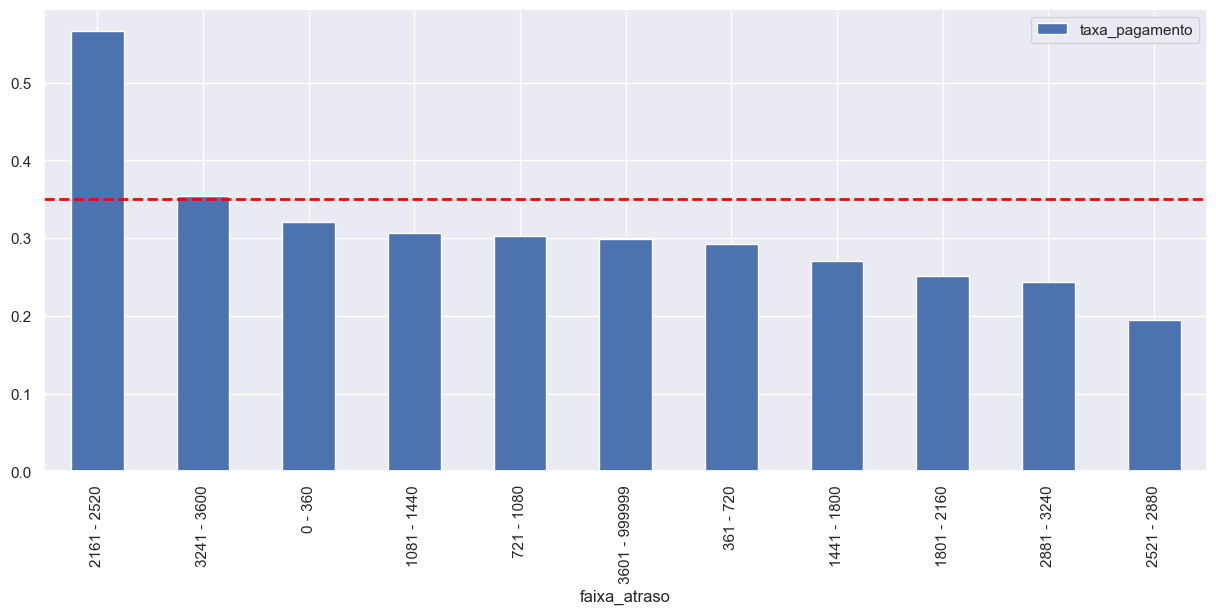

In [ ]:
FA_geral.sort_values(by='taxa_pagamento', ascending=False).plot(kind='bar', x='faixa_atraso', y='taxa_pagamento', figsize=(15,6))
plt.axhline(0.35, color='red', linestyle='--', linewidth=2)

In [ ]:
faixa_atraso = sql_df(query_FA_filtred)
faixa_atraso['dia'] = pd.to_datetime(faixa_atraso['dia'])
faixa_atraso['dia_mes'] = faixa_atraso['dia'].dt.day
faixa_atraso = faixa_atraso.set_index(faixa_atraso['dia'])

In [ ]:
faixa_atraso = faixa_atraso[['vencimentos_volume','pagamentos_volume']].groupby(by = [faixa_atraso.index.day, faixa_atraso['faixa_atraso']]).mean().reset_index()

In [ ]:
faixa_atraso['taxa_pagamento'] = faixa_atraso['pagamentos_volume'] / faixa_atraso['vencimentos_volume']

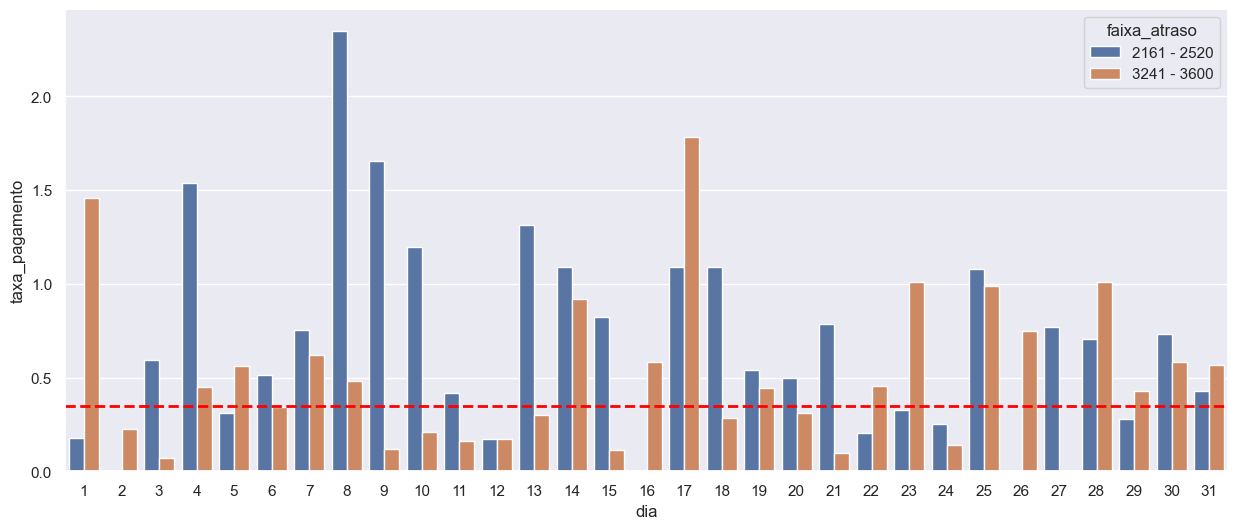

In [ ]:
plt.figure(figsize=(15,6))
sns.barplot(faixa_atraso, x='dia', y='taxa_pagamento', hue='faixa_atraso')
plt.axhline(0.35, color='red', linestyle='--', linewidth=2)

As datas de vencimento com melhor taxa de pagamento, de acordo com o desempenho geral e as melhores faixas de atraso (2161 - 2520 e 3241 - 3600), é o dia 5, 8, 17, 25.

A fim de entender qual dia vale apena mais estimulos, irei entender qual dia que as deals referente a essas datas de vencimento.

## Coligada

In [ ]:
query_coligada = ''' 
select
payment.due_date::date dia, 
case when upper(deal.segment) = 'RENNER' then 'RENNER' else segment end segment,
sum(value)::float vencimentos_volume,
sum(case when payment.status = 'PAYED' then value end)::float pagamentos_volume
from quiteja_lake.payment
left join quiteja_dados.ajuste_payment ap on ap.deal_id = payment.deal_id and ap.installment_number = payment.installment_number  
join kpi.credores on credores.creditor_id = payment.creditor_id
join quiteja_lake.deal on deal.id = payment.deal_id
where 1=1
and "quiteja_lake"."payment"."creditor_id" = 10
and CAST("quiteja_lake"."payment"."due_date" AS date) BETWEEN date '2024-01-01'
   AND date '2024-12-31'
and (ap.new_status in ('EXPIRED','PENDING') or (ap.new_status is null and payment.status not in ('DISCARTED')))
and payment.type = 'DOWN_PAYMENT'
and date(payment.due_date) < current_date
group by 1, 2 
order by 1, 2
'''

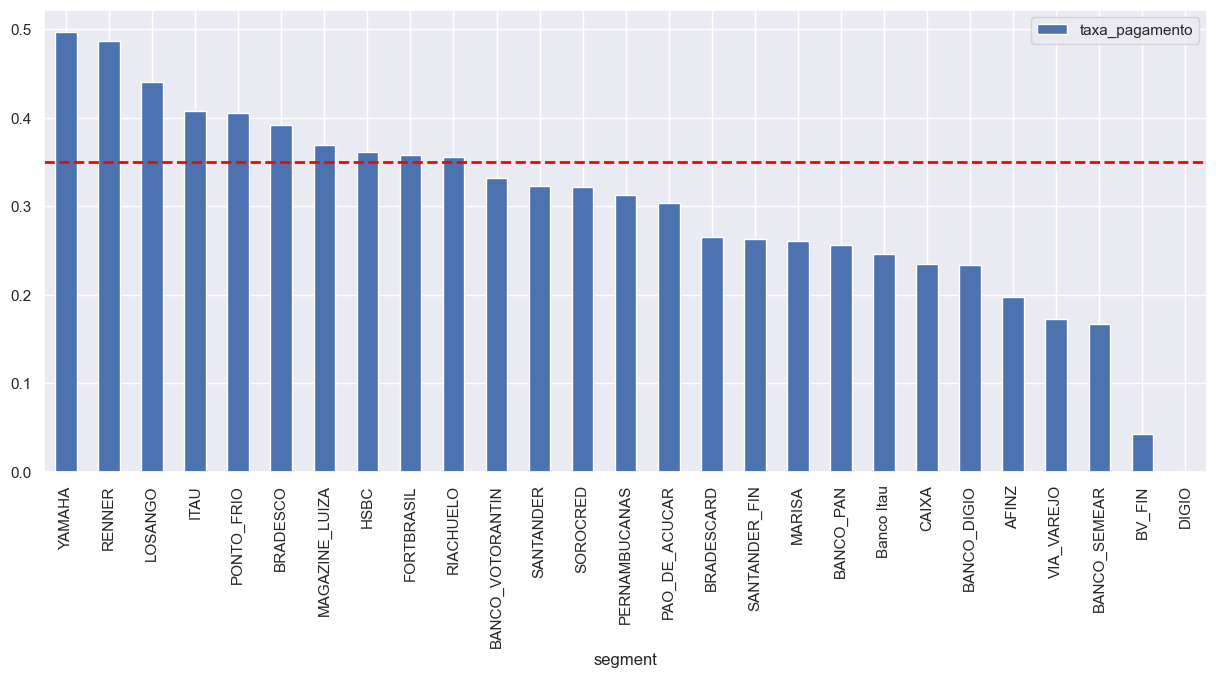

In [ ]:
coligada = sql_df(query_coligada)
coligada['dia'] = pd.to_datetime(coligada['dia'])
coligada['dia_mes'] = coligada['dia'].dt.day
coligada = coligada.set_index(coligada['dia'])
coligada = coligada[['vencimentos_volume','pagamentos_volume']].groupby(by = coligada['segment']).sum().reset_index()
coligada['taxa_pagamento'] = coligada['pagamentos_volume'] / coligada['vencimentos_volume']
coligada.sort_values(by='taxa_pagamento', ascending=False).plot(kind='bar', x='segment', y='taxa_pagamento', figsize=(15,6))
plt.axhline(0.35, color='red', linestyle='--', linewidth=2)


In [ ]:
coligada.sort_values(by='taxa_pagamento', ascending=False)

,segment,vencimentos_volume,pagamentos_volume,taxa_pagamento
26,YAMAHA,28883.87,14366.70,0.497395
20,RENNER,44849.37,21807.63,0.486242
14,LOSANGO,74945.80,33045.41,0.440924
13,ITAU,38670.64,15769.25,0.407784
19,PONTO_FRIO,4141.39,1677.18,0.404980
6,BRADESCO,126465.35,49497.15,0.391389
15,MAGAZINE_LUIZA,6544.11,2418.67,0.369595
12,HSBC,37183.77,13417.42,0.360841
11,FORTBRASIL,5187.36,1853.42,0.357295
21,RIACHUELO,194326.03,69147.92,0.355835


## Valor de Dívida 

In [ ]:

valor_divida = ''' 
select
(o.principal_value + o.interest_value) valor_divida
from quiteja_lake.payment
left join quiteja_dados.ajuste_payment ap on ap.deal_id = payment.deal_id and ap.installment_number = payment.installment_number  
join kpi.credores on credores.creditor_id = payment.creditor_id
join quiteja_lake.deal on deal.id = payment.deal_id
left join quiteja_lake.operation o on payment.deal_id = o.id and o.active is true 
where 1=1
and payment.status = 'PAYED'
and "quiteja_lake"."payment"."creditor_id" = 10
and CAST("quiteja_lake"."payment"."due_date" AS date) BETWEEN date '2024-01-01'
   AND date '2024-12-31'
and (ap.new_status in ('EXPIRED','PENDING') or (ap.new_status is null and payment.status not in ('DISCARTED')))
and payment.type = 'DOWN_PAYMENT'
and date(payment.due_date) < current_date
'''




In [ ]:
valor_divida = sql_df(valor_divida)

<Axes: xlabel='valor_divida', ylabel='Count'>

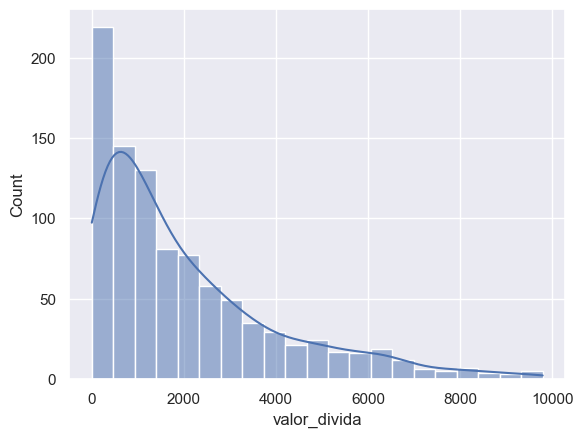

In [ ]:

sns.histplot(valor_divida[valor_divida['valor_divida'] <= 10000]['valor_divida'], kde=True)

Compreendido que as faixas de atraso com maior taxa de pagamento hoje são: 

2161 - 2520 e 3241 - 3600

Que as coligadas são:

YAMAHA, RENNER, LOSANGO, ITAU, PONTO_FRIO, BRADESCO, FORTBRASIL, MAGAZINE_LUIZA, HSBC, RIACHUELO

E que a maior ocorrência de clientes que pagam tem uma entrada de aproximadamente de R$ 100,00

Vou compreender como é feita a importação massiva para ver o que podemos melhorar.

# Importacao

In [ ]:
importacao_faixa_atraso = '''

select 
coalesce(d2.de,0) || ' - ' || coalesce(d2.ate, 999999) faixa_atraso,
count(*) total
from consolidacao_carteira.deal_10 d 
join quiteja_dados.dimensoes d2 on d.days_of_delay between coalesce(d2.de,0) and coalesce(d2.ate, 999999) and d2.creditor_id = 10 and d2.tipo_cluster = 'Atraso' 
where deal_tags_v2 like '%IMPORTACAO_MASSIVA%'
group by 1
order by 2 desc

'''


valor_divida_importacao = ''' 
select
debt_value
from consolidacao_carteira.deal_10 d 
where deal_tags_v2 like '%IMPORTACAO_MASSIVA%' 
'''


importacao_coligada = ''' 
select 
case when upper(segment) = 'RENNER' then 'RENNER' else segment end coligada,
count(*) total
from consolidacao_carteira.deal_10 d 
where deal_tags_v2 like '%IMPORTACAO_MASSIVA%'
group by 1
order by 2 desc
'''


valor_divida_importacao = sql_df(valor_divida_importacao)
importacao_faixa_atraso = sql_df(importacao_faixa_atraso)
importacao_coligada = sql_df(importacao_coligada)

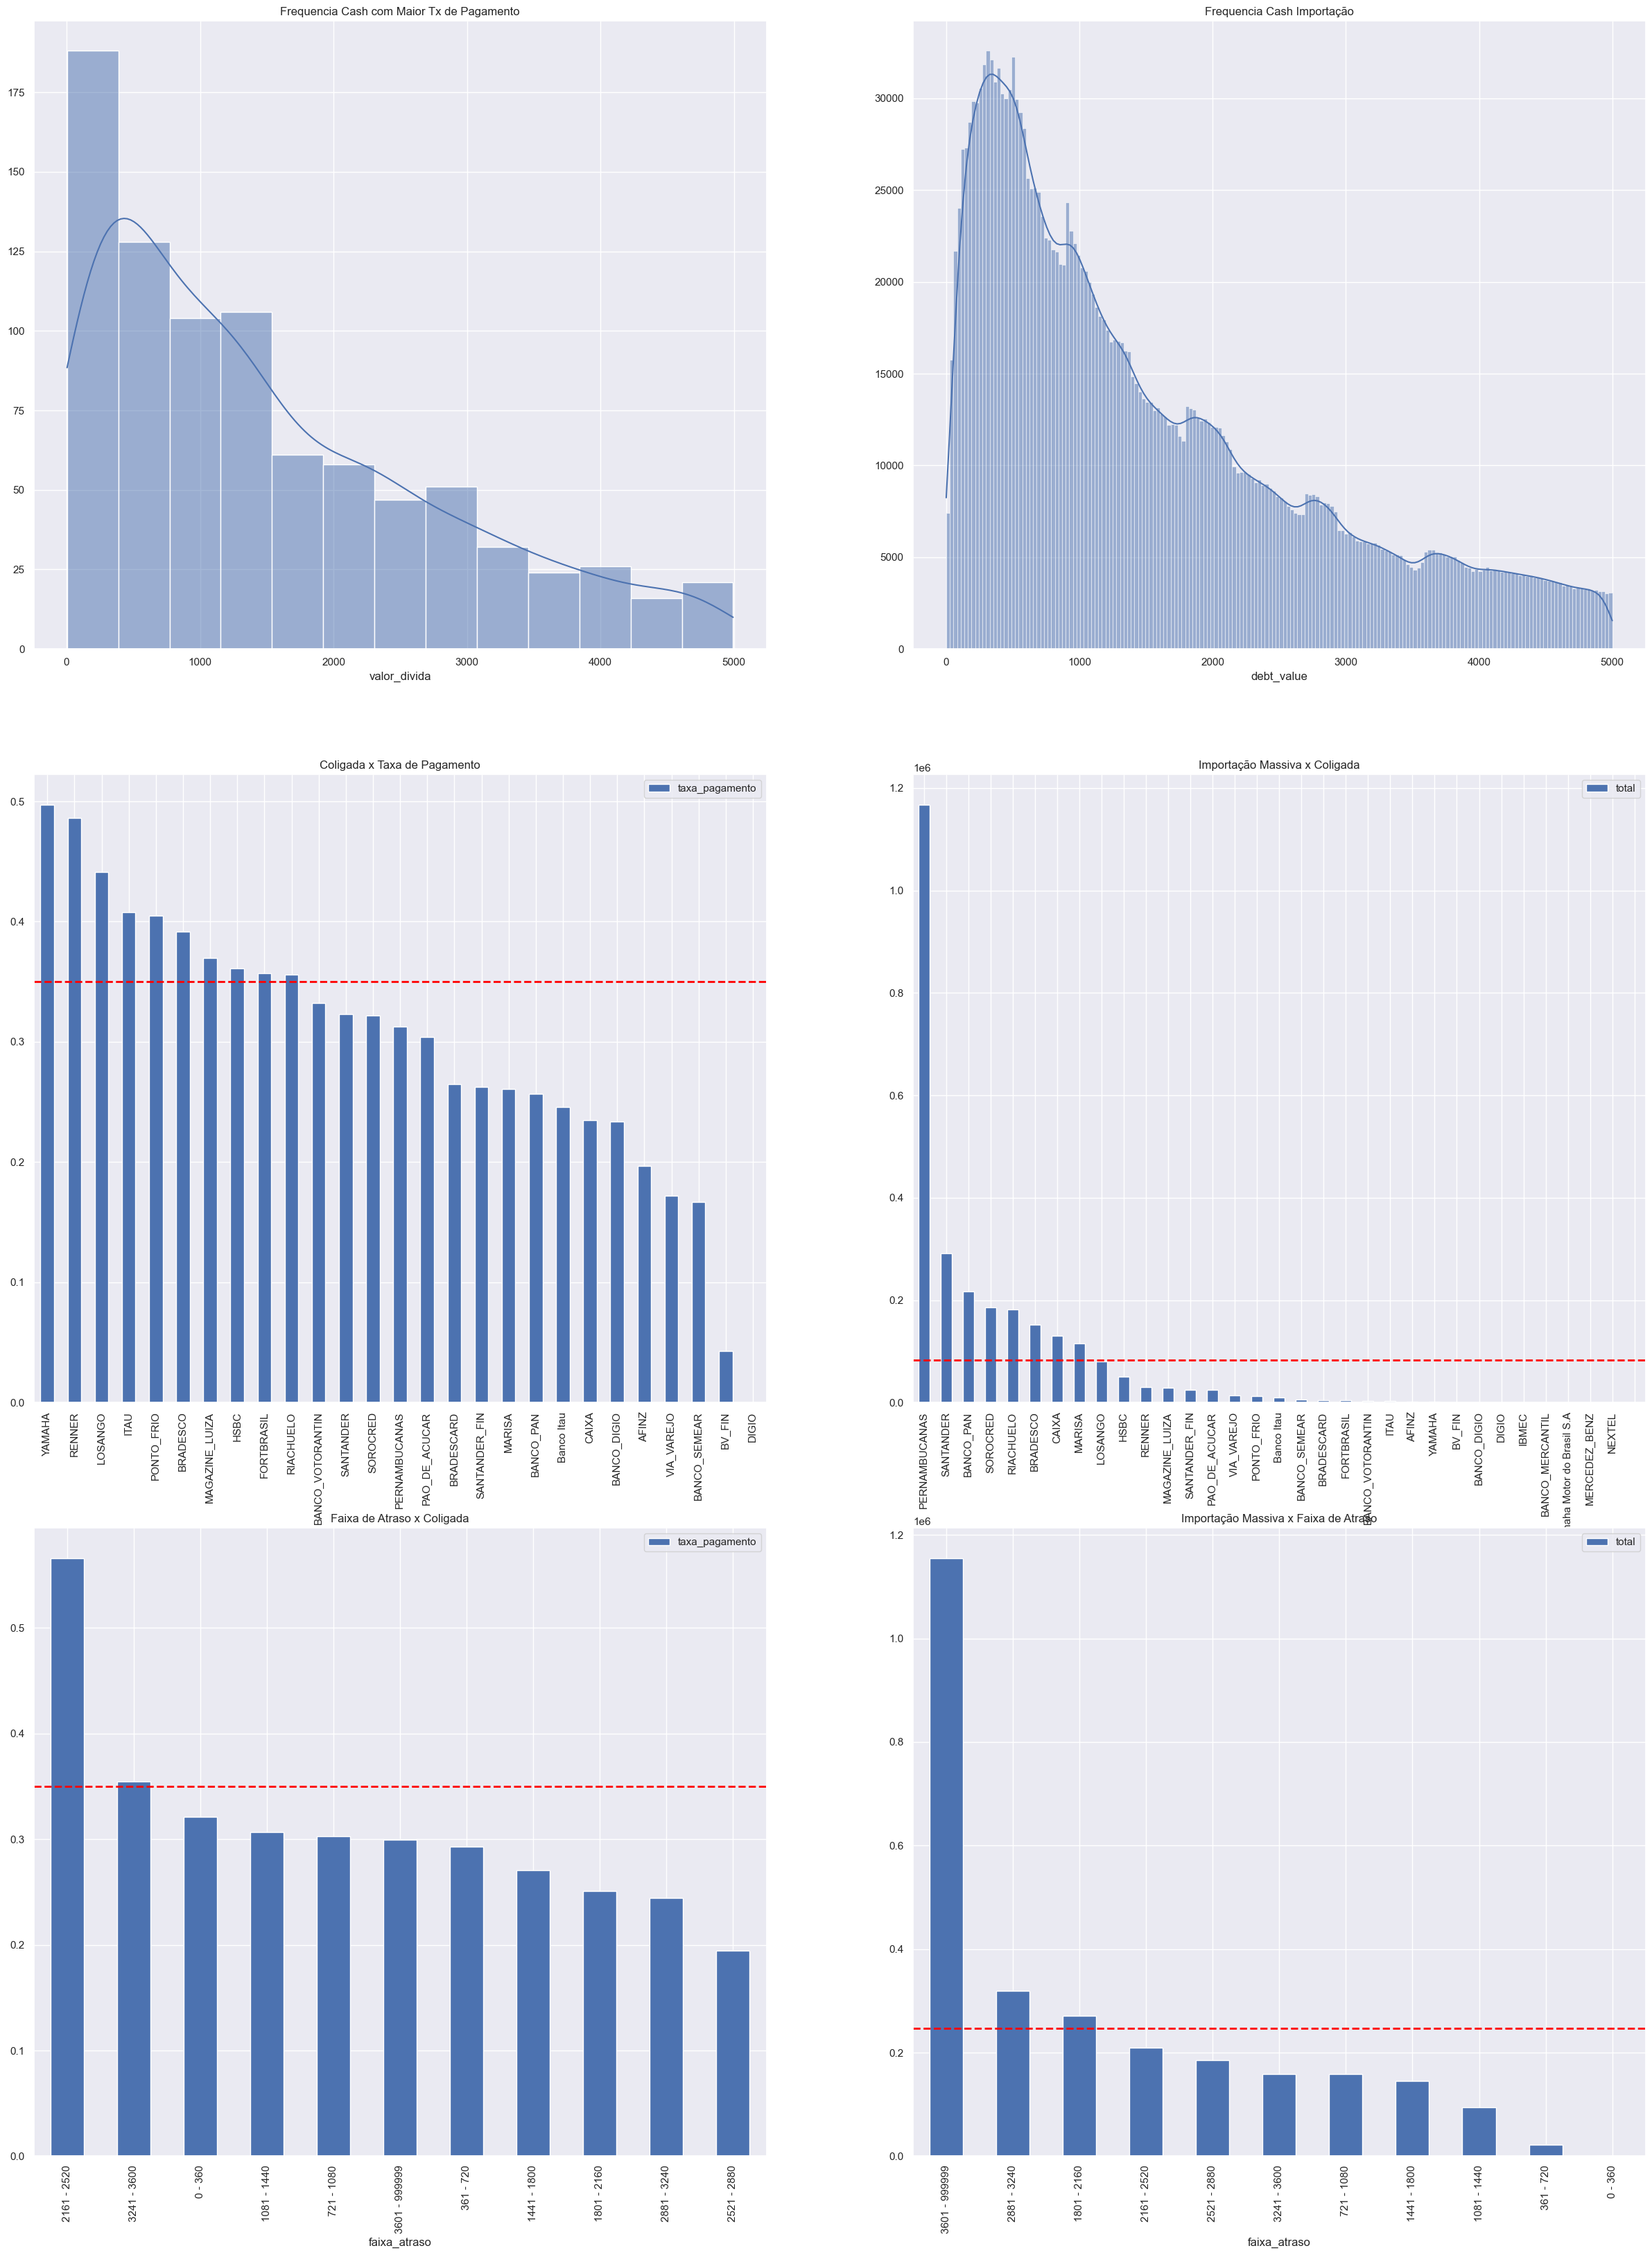

In [ ]:
fig, axes = plt.subplots(3,2, figsize=(30,40))
sns.histplot(valor_divida[valor_divida['valor_divida'] <= 5000]['valor_divida'], kde=True, ax= axes[0,0])
axes[0,0].set_title('Frequencia Cash com Maior Tx de Pagamento')
axes[0,0].set_ylabel('')
sns.histplot(valor_divida_importacao[valor_divida_importacao['debt_value'] <= 5000]['debt_value'], kde=True, ax= axes[0,1])
axes[0,1].set_title('Frequencia Cash Importação')
axes[0,1].set_ylabel('')
coligada.sort_values(by='taxa_pagamento', ascending=False).plot(kind='bar', x='segment', y='taxa_pagamento', ax= axes[1,0])
axes[1,0].axhline(0.35, color='red', linestyle='--', linewidth=2)
axes[1,0].set_title('Coligada x Taxa de Pagamento')
importacao_coligada.sort_values(by='total', ascending=False).plot(kind='bar', x='coligada', y='total', ax= axes[1,1])
axes[1,1].axhline(importacao_coligada['total'].mean(), color='red', linestyle='--', linewidth=2)
axes[1,1].set_title('Importação Massiva x Coligada')
FA_geral.sort_values(by='taxa_pagamento', ascending=False).plot(kind='bar', x='faixa_atraso', y='taxa_pagamento', ax= axes[2,0])
axes[2,0].axhline(0.35, color='red', linestyle='--', linewidth=2)
axes[2,0].set_title('Faixa de Atraso x Coligada')
importacao_faixa_atraso.sort_values(by='total', ascending=False).plot(kind='bar', x='faixa_atraso', y='total', ax= axes[2,1])
axes[2,1].axhline(importacao_faixa_atraso['total'].mean(), color='red', linestyle='--', linewidth=2)
axes[2,1].set_title('Importação Massiva x Faixa de Atraso');

## Propostas

In [ ]:
query_producao = ''' 
select
payment.due_date::date dia_vencimento, 
p.agreed_at::date dia_producao,
count(payment.deal_id)
from quiteja_lake.payment
left join quiteja_dados.ajuste_payment ap on ap.deal_id = payment.deal_id and ap.installment_number = payment.installment_number  
join kpi.credores on credores.creditor_id = payment.creditor_id
join quiteja_lake.deal on deal.id = payment.deal_id
--left join quiteja_lake.operation o on payment.deal_id = o.id and o.active is true 
join quiteja_lake.proposal p on p.deal_id = payment.deal_id and p.status = 'AGREED'
where 1=1
and "quiteja_lake"."payment"."creditor_id" = 10
and CAST("quiteja_lake"."payment"."due_date" AS date) BETWEEN date '2024-01-01'
   AND date '2024-12-31'
and (ap.new_status in ('EXPIRED','PENDING') or (ap.new_status is null and payment.status not in ('DISCARTED')))
and payment.type = 'DOWN_PAYMENT'
and date_part('day',payment.due_date) in (5, 8, 17, 25)
group by 1, 2
order by 1
'''

In [ ]:
producao = sql_df(query_producao)
producao['dia_vencimento'] = pd.to_datetime(producao['dia_vencimento'])
producao['dia_vencimento'] = producao['dia_vencimento'].dt.day
producao['dia_producao'] = pd.to_datetime(producao['dia_producao'])
producao['dia_producao'] = producao['dia_producao'].dt.day

In [ ]:
producao[producao['dia_vencimento'] == 5]['count'].groupby(by=producao['dia_producao']).mean().sort_values(ascending=False)

dia_producao
27    83.000000
4     38.333333
28    25.250000
29    20.250000
2      8.800000
3      8.000000
30     7.750000
1      5.800000
31     5.666667
5      4.750000
Name: count, dtype: float64

Text(0.5, 0, '')

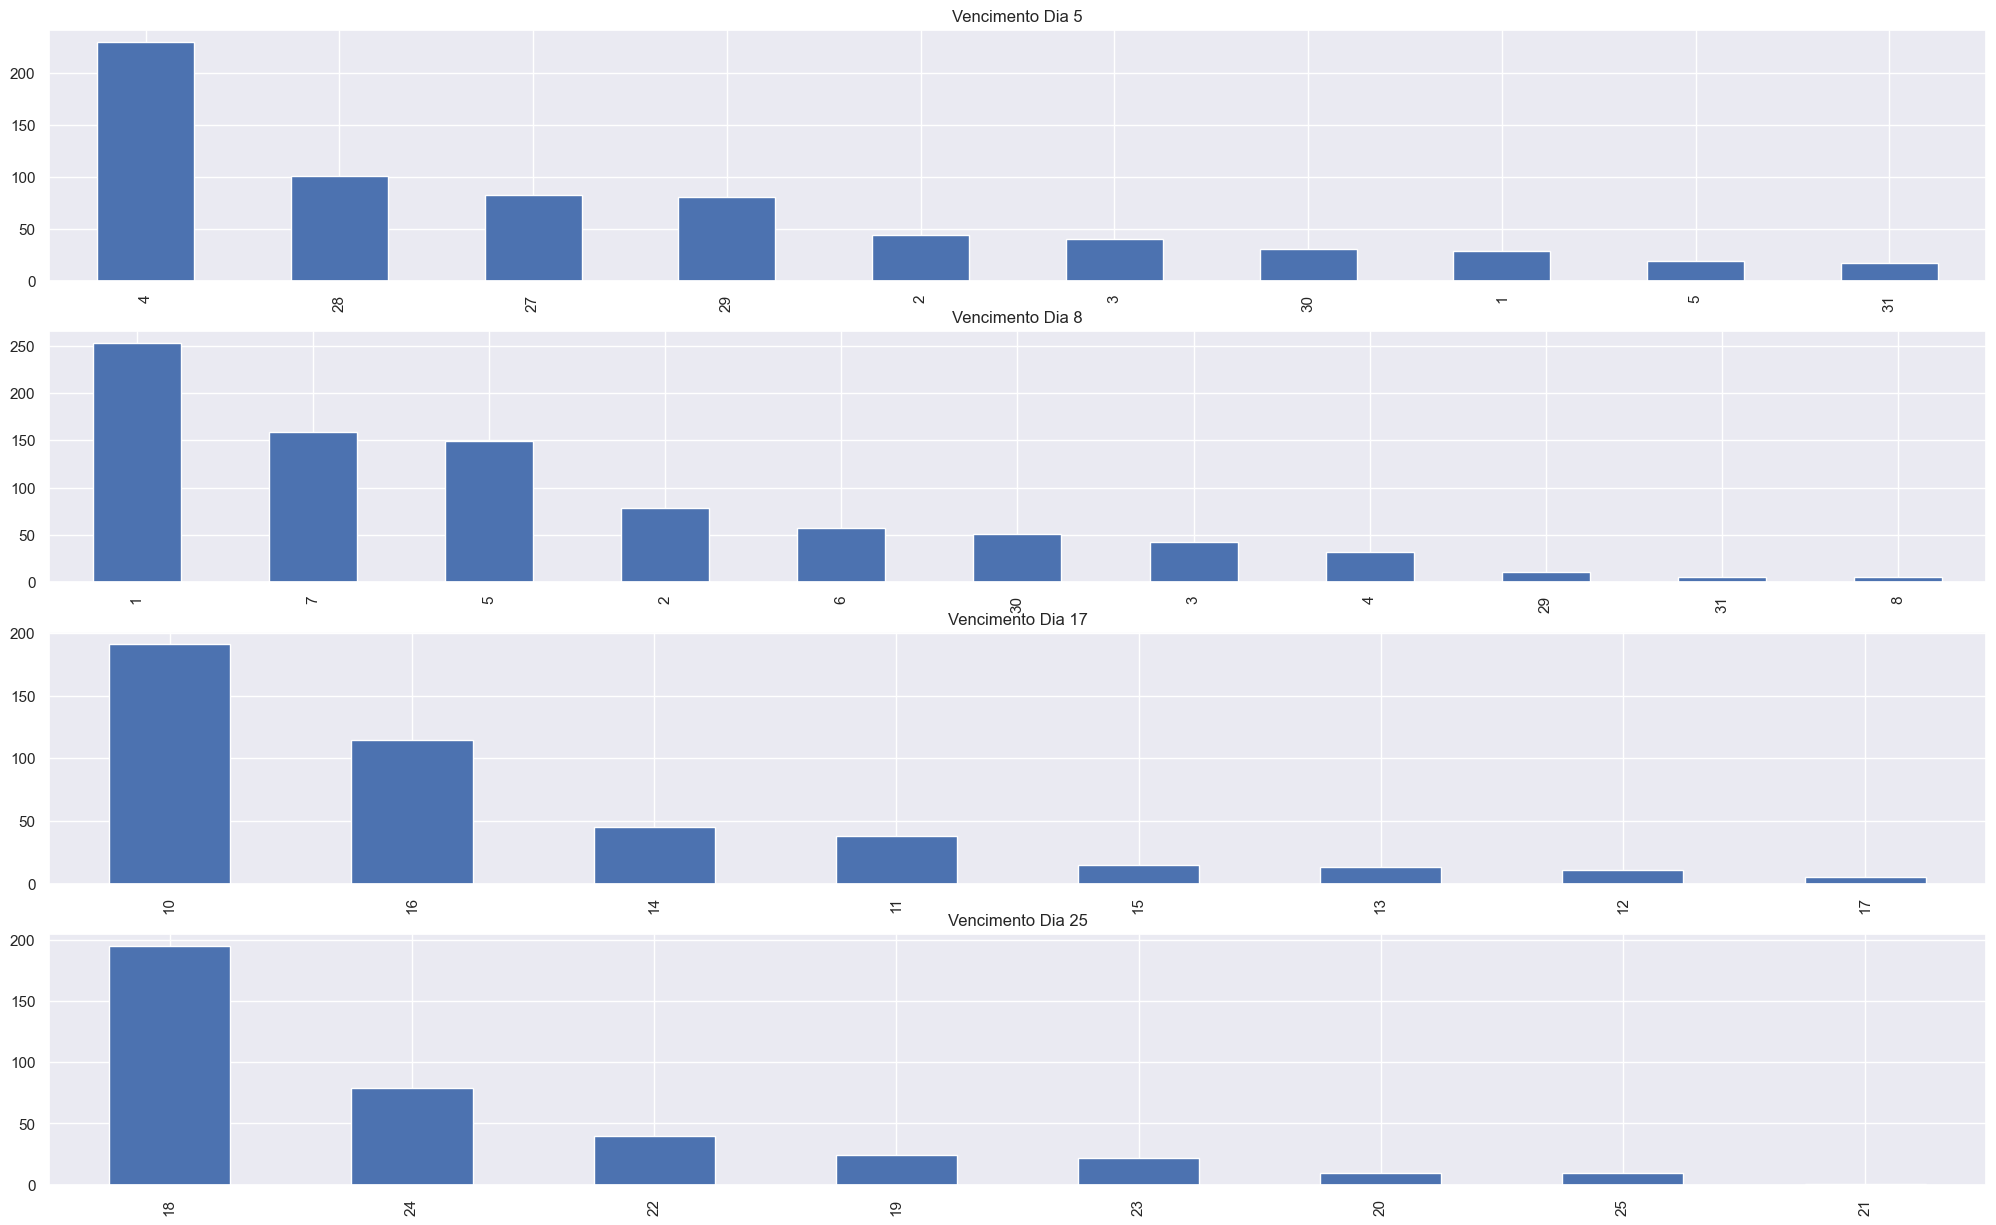

In [ ]:
fig, axs = plt.subplots(4,1, figsize=(25,15))
producao[producao['dia_vencimento'] == 5]['count'].groupby(by=producao['dia_producao']).sum().sort_values(ascending=False).plot(kind='bar', ax= axs[0], title='Vencimento Dia 5')
axs[0].set_xlabel('')
producao[producao['dia_vencimento'] == 8]['count'].groupby(by=producao['dia_producao']).sum().sort_values(ascending=False).plot(kind='bar', ax= axs[1], title='Vencimento Dia 8')
axs[1].set_xlabel('')
producao[producao['dia_vencimento'] == 17]['count'].groupby(by=producao['dia_producao']).sum().sort_values(ascending=False).plot(kind='bar', ax= axs[2], title='Vencimento Dia 17')
axs[2].set_xlabel('')
producao[producao['dia_vencimento'] == 25]['count'].groupby(by=producao['dia_producao']).sum().sort_values(ascending=False).plot(kind='bar', ax= axs[3], title='Vencimento Dia 25')
axs[3].set_xlabel('')


# 31    0.407199
# 28    0.382609
# 25    0.380056


Text(0.5, 0, '')

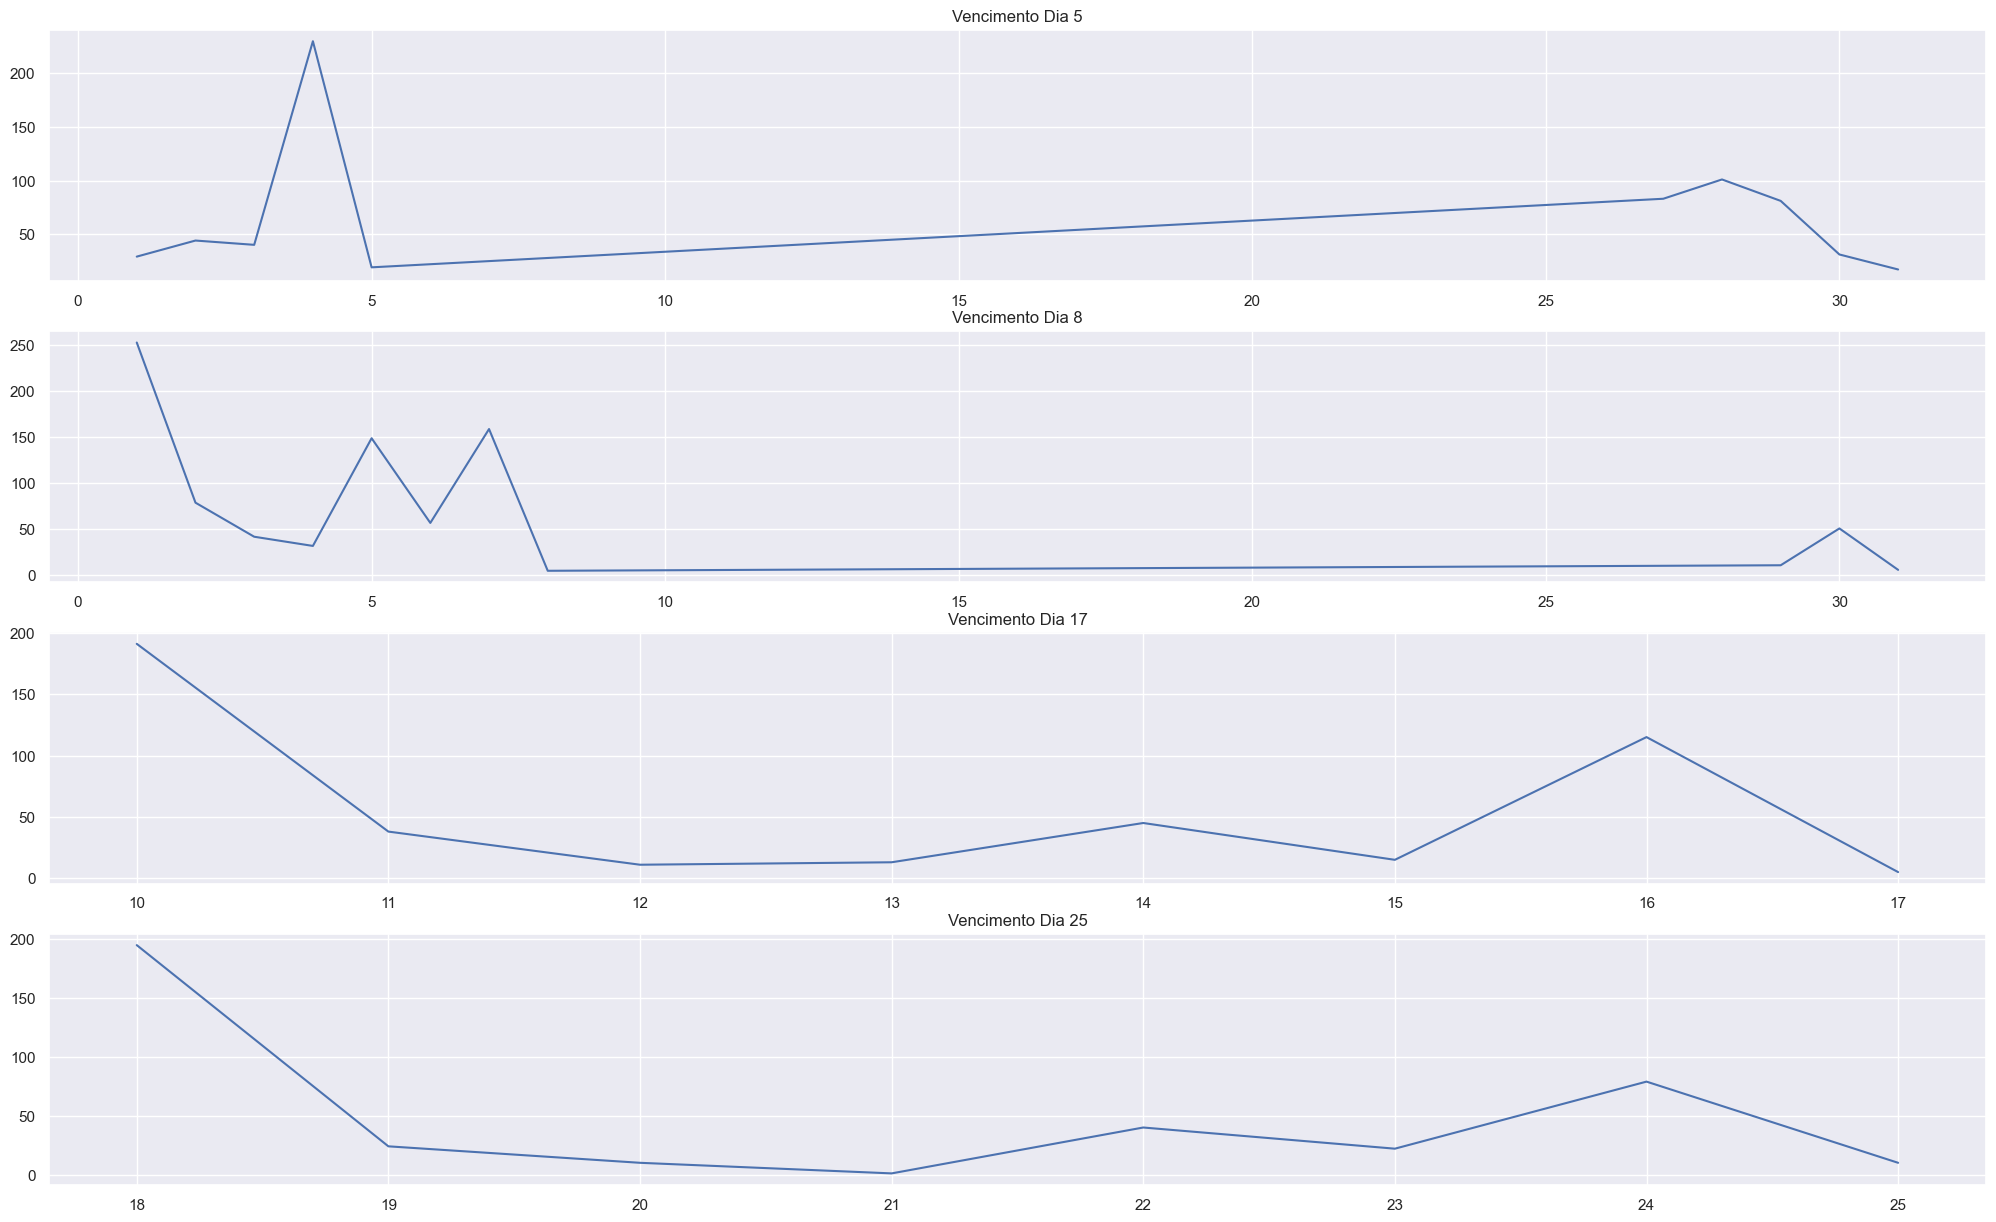

In [ ]:
fig, axs = plt.subplots(4,1, figsize=(25,15))
producao[producao['dia_vencimento'] == 5]['count'].groupby(by=producao['dia_producao']).sum().plot(ax= axs[0], title='Vencimento Dia 5')
axs[0].set_xlabel('')
producao[producao['dia_vencimento'] == 8]['count'].groupby(by=producao['dia_producao']).sum().plot(ax= axs[1], title='Vencimento Dia 8')
axs[1].set_xlabel('')
producao[producao['dia_vencimento'] == 17]['count'].groupby(by=producao['dia_producao']).sum().plot(ax= axs[2], title='Vencimento Dia 17')
axs[2].set_xlabel('')
producao[producao['dia_vencimento'] == 25]['count'].groupby(by=producao['dia_producao']).sum().plot(ax= axs[3], title='Vencimento Dia 25')
axs[3].set_xlabel('')

In [ ]:
query_producao_fa = ''' 
select
payment.due_date::date dia_vencimento, 
dim.cod_cluster,
coalesce(dim.de,0) || ' - ' || coalesce(dim.ate,999999) faixa_atraso,
p.agreed_at::date dia_producao,
count(payment.deal_id)
from quiteja_lake.payment
left join quiteja_dados.ajuste_payment ap on ap.deal_id = payment.deal_id and ap.installment_number = payment.installment_number  
join kpi.credores on credores.creditor_id = payment.creditor_id
join quiteja_lake.deal on deal.id = payment.deal_id
left join quiteja_lake.operation o on payment.deal_id = o.id and o.active is true 
join quiteja_dados.dimensoes dim on o.days_of_delay between coalesce(dim.de,0) and coalesce(dim.ate, 999999) and dim.creditor_id = 10 and tipo_cluster = 'Atraso'
join quiteja_lake.proposal p on p.deal_id = payment.deal_id and p.status = 'AGREED'
where 1=1
and "quiteja_lake"."payment"."creditor_id" = 10
and CAST("quiteja_lake"."payment"."due_date" AS date) BETWEEN date '2024-01-01'
   AND date '2024-12-31'
and (ap.new_status in ('EXPIRED','PENDING') or (ap.new_status is null and payment.status not in ('DISCARTED')))
and payment.type = 'DOWN_PAYMENT'
and date_part('day',payment.due_date) in (5, 8, 17, 25)
and cod_cluster in (4,10)
group by 1, 2, 3,4
order by 1,2
'''

In [ ]:
producao_fa = sql_df(query_producao_fa)
producao_fa['dia_vencimento'] = pd.to_datetime(producao_fa['dia_vencimento'])
producao_fa['dia_vencimento'] = producao_fa['dia_vencimento'].dt.day
producao_fa['dia_producao'] = pd.to_datetime(producao_fa['dia_producao'])
producao_fa['dia_producao'] = producao_fa['dia_producao'].dt.day

In [ ]:
producao_fa[producao_fa['dia_vencimento'] == 5]['count'].groupby(by=[producao_fa['dia_producao'],producao_fa['faixa_atraso']]).sum().unstack().fillna(0)

faixa_atraso,1081 - 1440,3241 - 3600
dia_producao,,
1,1.0,0.0
2,3.0,0.0
4,10.0,6.0
5,1.0,0.0
27,4.0,3.0
28,2.0,2.0
29,1.0,1.0


Text(0.5, 0, '')

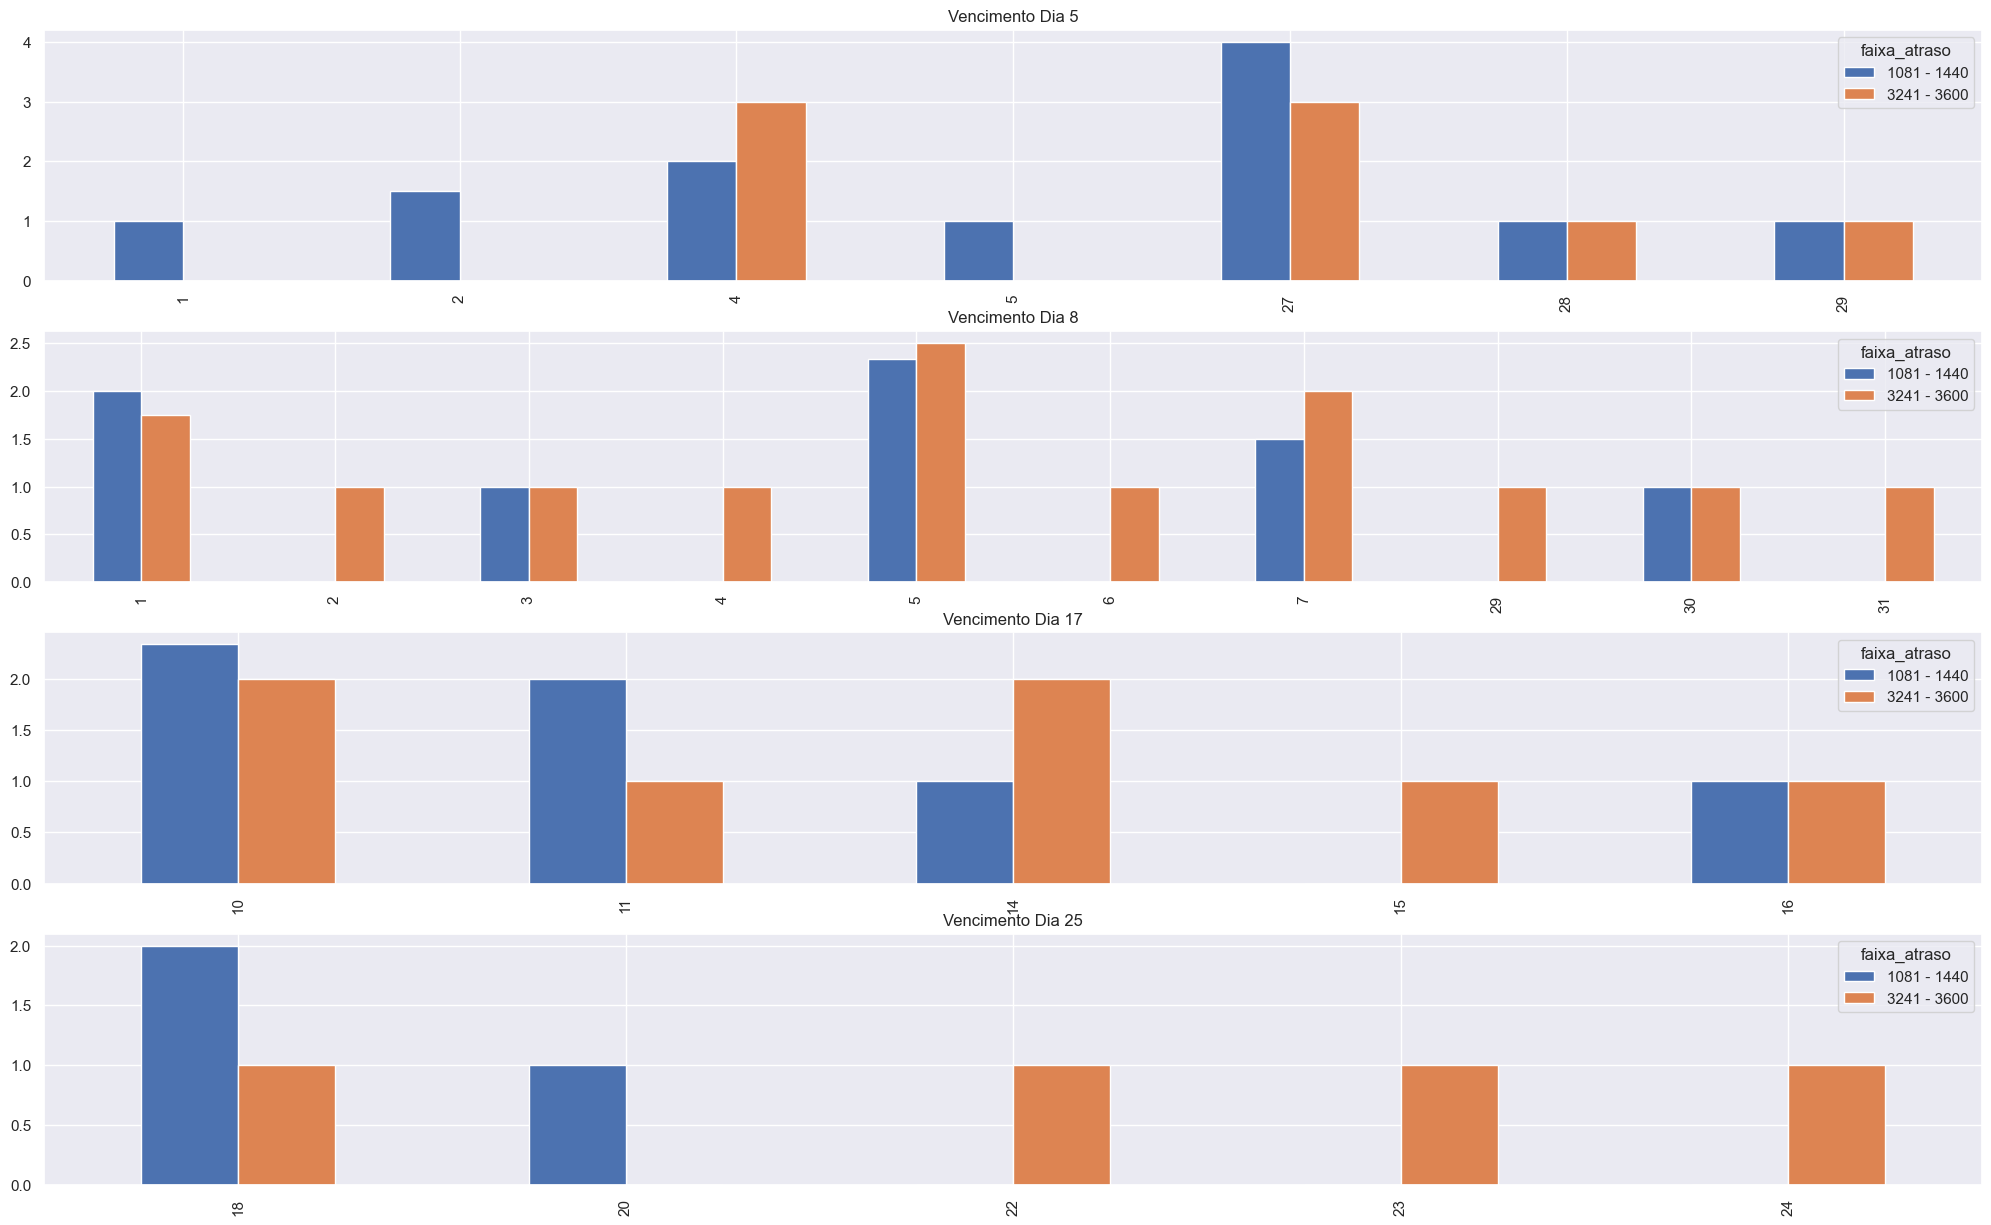

In [ ]:
fig, axs = plt.subplots(4,1, figsize=(25,15))
producao_fa[producao_fa['dia_vencimento'] == 5]['count'].groupby(by=[producao_fa['dia_producao'],producao_fa['faixa_atraso']]).mean().unstack().fillna(0).plot(kind='bar', ax= axs[0], title='Vencimento Dia 5')
axs[0].set_xlabel('')
producao_fa[producao_fa['dia_vencimento'] == 8]['count'].groupby(by=[producao_fa['dia_producao'],producao_fa['faixa_atraso']]).mean().unstack().fillna(0).plot(kind='bar', ax= axs[1], title='Vencimento Dia 8')
axs[1].set_xlabel('')
producao_fa[producao_fa['dia_vencimento'] == 17]['count'].groupby(by=[producao_fa['dia_producao'],producao_fa['faixa_atraso']]).mean().unstack().fillna(0).plot(kind='bar', ax= axs[2], title='Vencimento Dia 17')
axs[2].set_xlabel('')
producao_fa[producao_fa['dia_vencimento'] == 25]['count'].groupby(by=[producao_fa['dia_producao'],producao_fa['faixa_atraso']]).mean().unstack().fillna(0).plot(kind='bar', ax= axs[3], title='Vencimento Dia 25')
axs[3].set_xlabel('')

In [ ]:
maior_producao = ''' 
select 
created_at,
count(*) total_producao,
sum(down_payment) promessas, 
sum(case when down_payment_payed is not null then down_payment_payed else 0 end) pagamentos
from quiteja_dados.analitico_producao_10 ap 
where created_at > '2022-01-01'
group  by 1
order by 1
'''

In [ ]:
maior_producao = sql_df(maior_producao)
maior_producao['created_at'] = pd.to_datetime(maior_producao['created_at'])
maior_producao['dia_mes'] = maior_producao['created_at'].dt.day
maior_producao.set_index('created_at', inplace=True)

In [ ]:
dia_producao = maior_producao.groupby(by ='dia_mes').mean('total_producao').sort_values(by='total_producao', ascending=False)
dia_producao['taxa_pagamento'] = dia_producao['pagamentos'] / dia_producao['promessas']
dia_producao['perc_producao'] = dia_producao['total_producao'] / sum(dia_producao['total_producao'])
dia_producao['perc_promessas'] = dia_producao['promessas'] / sum(dia_producao['promessas'])
dia_producao['perc_pagamentos'] = dia_producao['pagamentos'] / sum(dia_producao['pagamentos'])

In [ ]:
dia_producao.sort_values(by='total_producao', ascending=False).head(50)

,total_producao,promessas,pagamentos,taxa_pagamento,perc_producao,perc_promessas,perc_pagamentos
dia_mes,,,,,,,
4,172.105263,31940.364316,12500.510837,0.391370,0.053429,0.042711,0.052452
20,156.277778,33680.164922,14757.701150,0.438172,0.048515,0.045037,0.061924
5,142.631579,29329.872458,10777.974200,0.367474,0.044279,0.039220,0.045225
3,136.894737,29354.991089,9198.397816,0.313350,0.042498,0.039254,0.038597
19,121.555556,23684.545756,8989.632311,0.379557,0.037736,0.031671,0.037721
27,112.777778,25713.355239,8258.567244,0.321178,0.035011,0.034384,0.034653
10,111.722222,25190.546339,8514.920628,0.338020,0.034683,0.033685,0.035729
6,109.157895,26709.049263,8081.914737,0.302591,0.033887,0.035716,0.033912
15,108.647059,26279.340188,7605.274018,0.289401,0.033729,0.035141,0.031912


In [ ]:
dia_producao.corr()

,total_producao,promessas,pagamentos,taxa_pagamento,perc_producao,perc_promessas,perc_pagamentos
total_producao,1.000000,0.874143,0.912552,0.670146,1.000000,0.874143,0.912552
promessas,0.874143,1.000000,0.864737,0.449225,0.874143,1.000000,0.864737
pagamentos,0.912552,0.864737,1.000000,0.829813,0.912552,0.864737,1.000000
taxa_pagamento,0.670146,0.449225,0.829813,1.000000,0.670146,0.449225,0.829813
perc_producao,1.000000,0.874143,0.912552,0.670146,1.000000,0.874143,0.912552
perc_promessas,0.874143,1.000000,0.864737,0.449225,0.874143,1.000000,0.864737
perc_pagamentos,0.912552,0.864737,1.000000,0.829813,0.912552,0.864737,1.000000


Para depois do almoço 

- Abrir por faixas - OK
- Ver a relação dos dias com maior taxa de pagamento que dia que foi feito a proposta Ok
- Ver dos dias com maior produção, qual possui a maior taxa de pagamento Ok
- Entender qual o perfil de cliente com melhor taxa de pagamento, abrindo por faixa de atraso e coligada. Após o isso verificar a importação e entender qual é o público que está sendo syncado na importação Massiva.

Após essas análises verificar 

- Regressão para entender quais variaveis que mais impactam  na taxa de atraso

# Conclusões

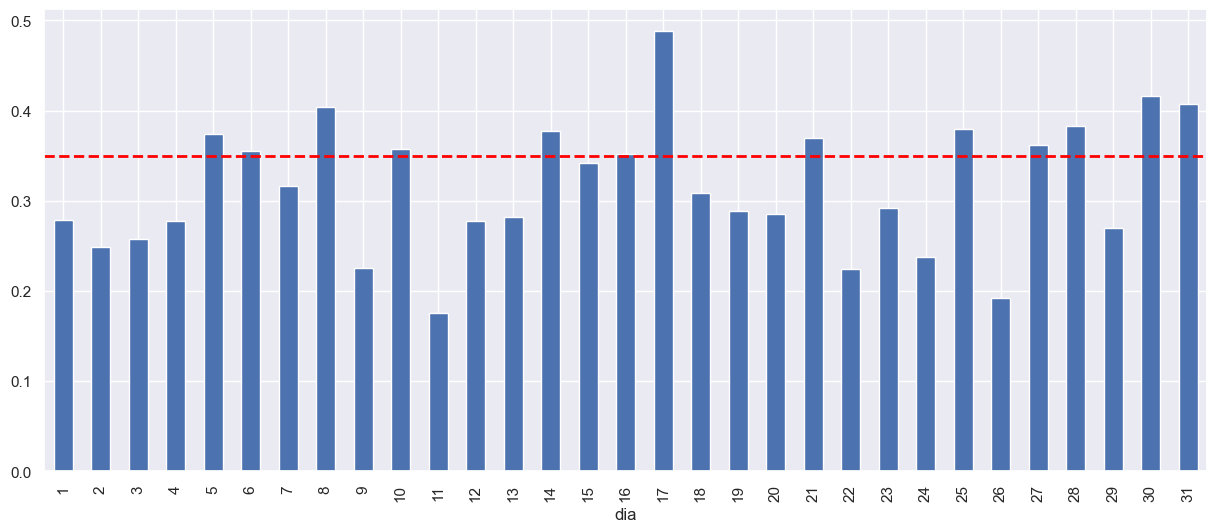

In [ ]:
plt.figure(figsize=(15,6))
tx_pagamento['tx_pagamento_volume'].groupby(tx_pagamento.index.day).mean().plot(kind='bar')
plt.axhline(0.35, color='red', linestyle='--', linewidth=2)

Text(0.5, 0, '')

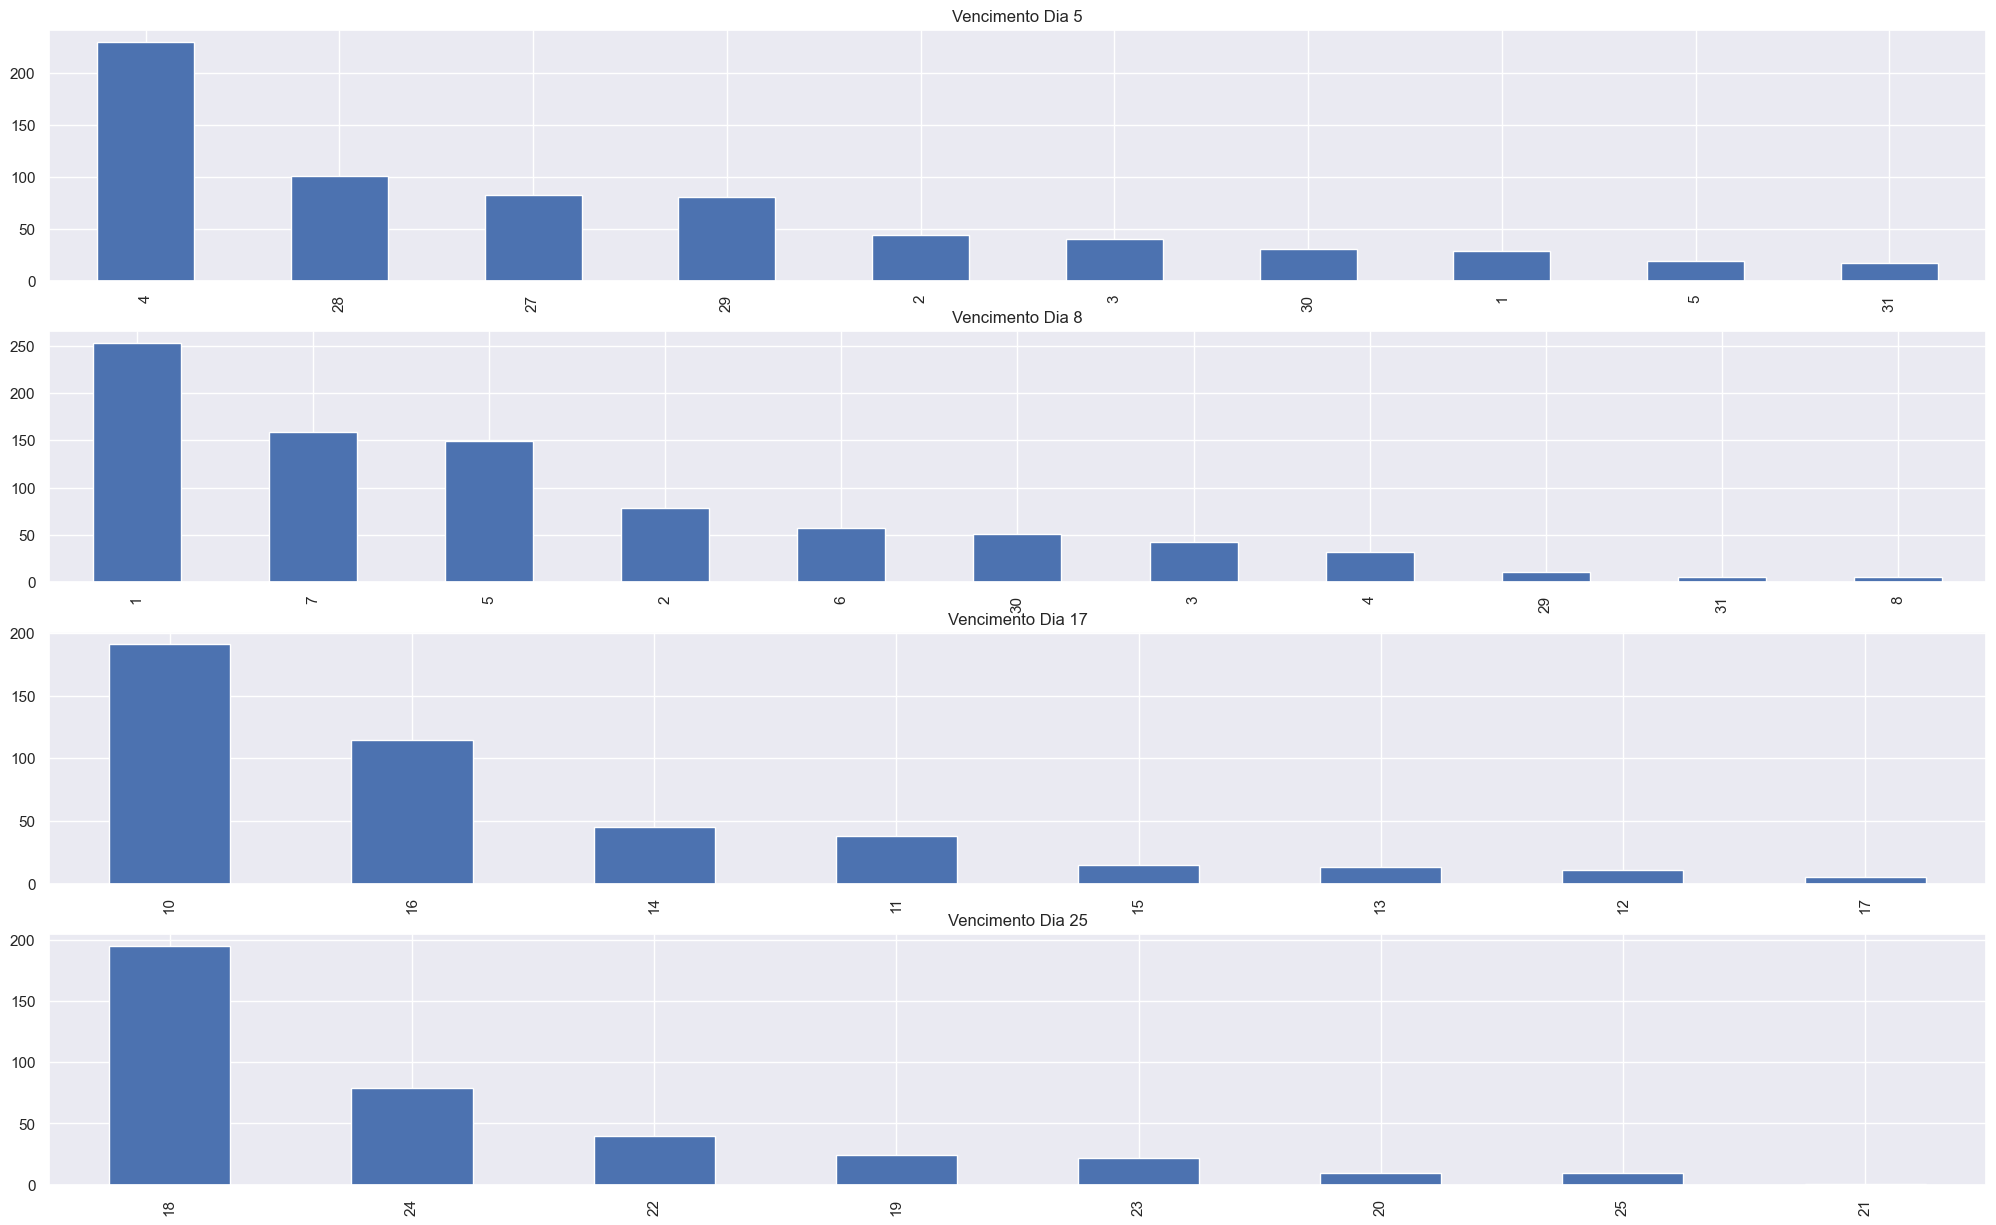

In [ ]:
fig, axs = plt.subplots(4,1, figsize=(25,15))
producao[producao['dia_vencimento'] == 5]['count'].groupby(by=producao['dia_producao']).sum().sort_values(ascending=False).plot(kind='bar', ax= axs[0], title='Vencimento Dia 5')
axs[0].set_xlabel('')
producao[producao['dia_vencimento'] == 8]['count'].groupby(by=producao['dia_producao']).sum().sort_values(ascending=False).plot(kind='bar', ax= axs[1], title='Vencimento Dia 8')
axs[1].set_xlabel('')
producao[producao['dia_vencimento'] == 17]['count'].groupby(by=producao['dia_producao']).sum().sort_values(ascending=False).plot(kind='bar', ax= axs[2], title='Vencimento Dia 17')
axs[2].set_xlabel('')
producao[producao['dia_vencimento'] == 25]['count'].groupby(by=producao['dia_producao']).sum().sort_values(ascending=False).plot(kind='bar', ax= axs[3], title='Vencimento Dia 25')
axs[3].set_xlabel('')

Text(0.5, 0, '')

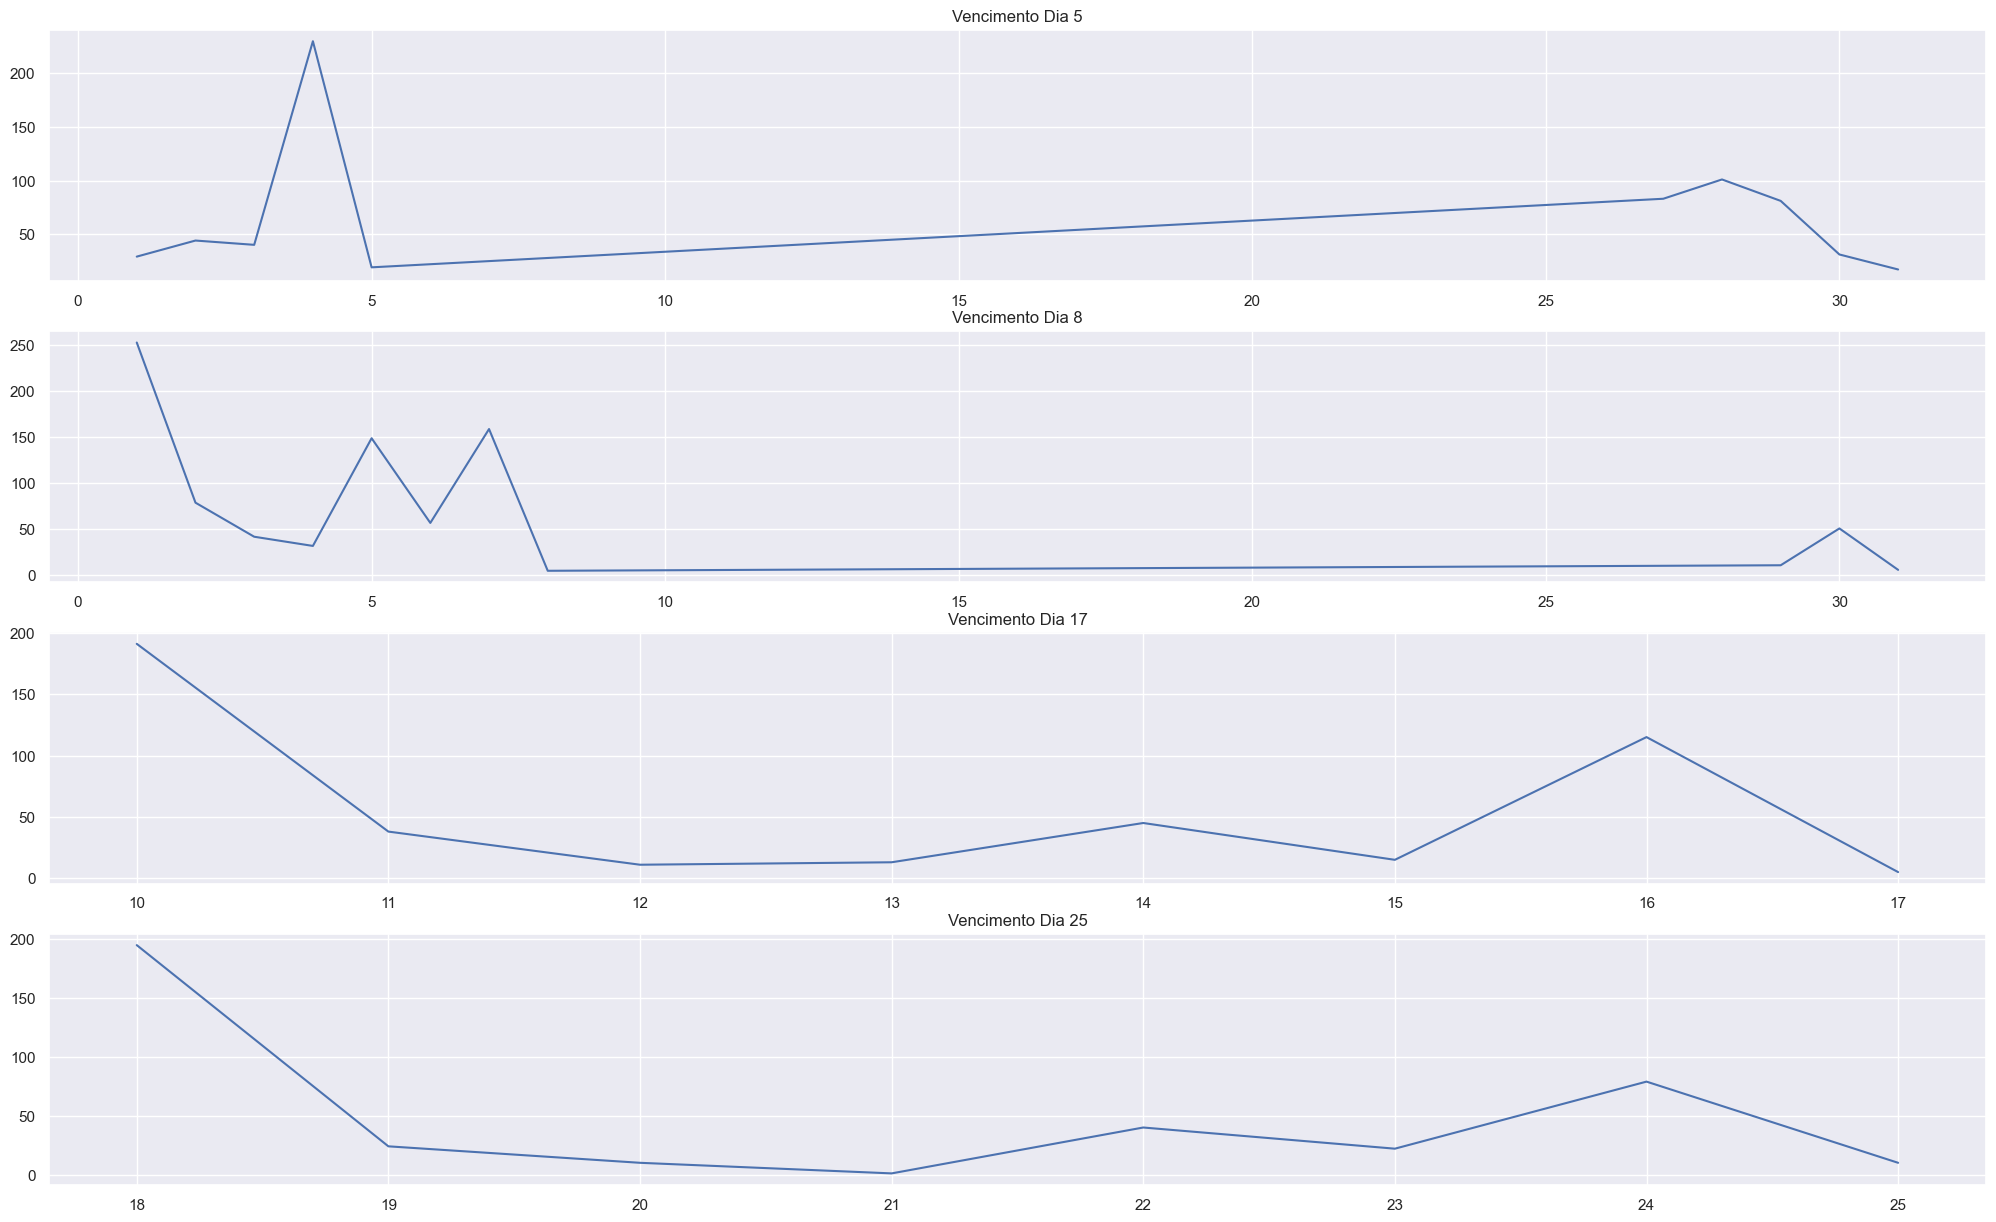

In [ ]:
fig, axs = plt.subplots(4,1, figsize=(25,15))
producao[producao['dia_vencimento'] == 5]['count'].groupby(by=producao['dia_producao']).sum().plot(ax= axs[0], title='Vencimento Dia 5')
axs[0].set_xlabel('')
producao[producao['dia_vencimento'] == 8]['count'].groupby(by=producao['dia_producao']).sum().plot(ax= axs[1], title='Vencimento Dia 8')
axs[1].set_xlabel('')
producao[producao['dia_vencimento'] == 17]['count'].groupby(by=producao['dia_producao']).sum().plot(ax= axs[2], title='Vencimento Dia 17')
axs[2].set_xlabel('')
producao[producao['dia_vencimento'] == 25]['count'].groupby(by=producao['dia_producao']).sum().plot(ax= axs[3], title='Vencimento Dia 25')
axs[3].set_xlabel('')

In [ ]:
coligada.sort_values(by='taxa_pagamento', ascending=False).head(10)['segment']

26            YAMAHA
20            RENNER
14           LOSANGO
13              ITAU
19        PONTO_FRIO
6           BRADESCO
15    MAGAZINE_LUIZA
12              HSBC
11        FORTBRASIL
21         RIACHUELO
Name: segment, dtype: object

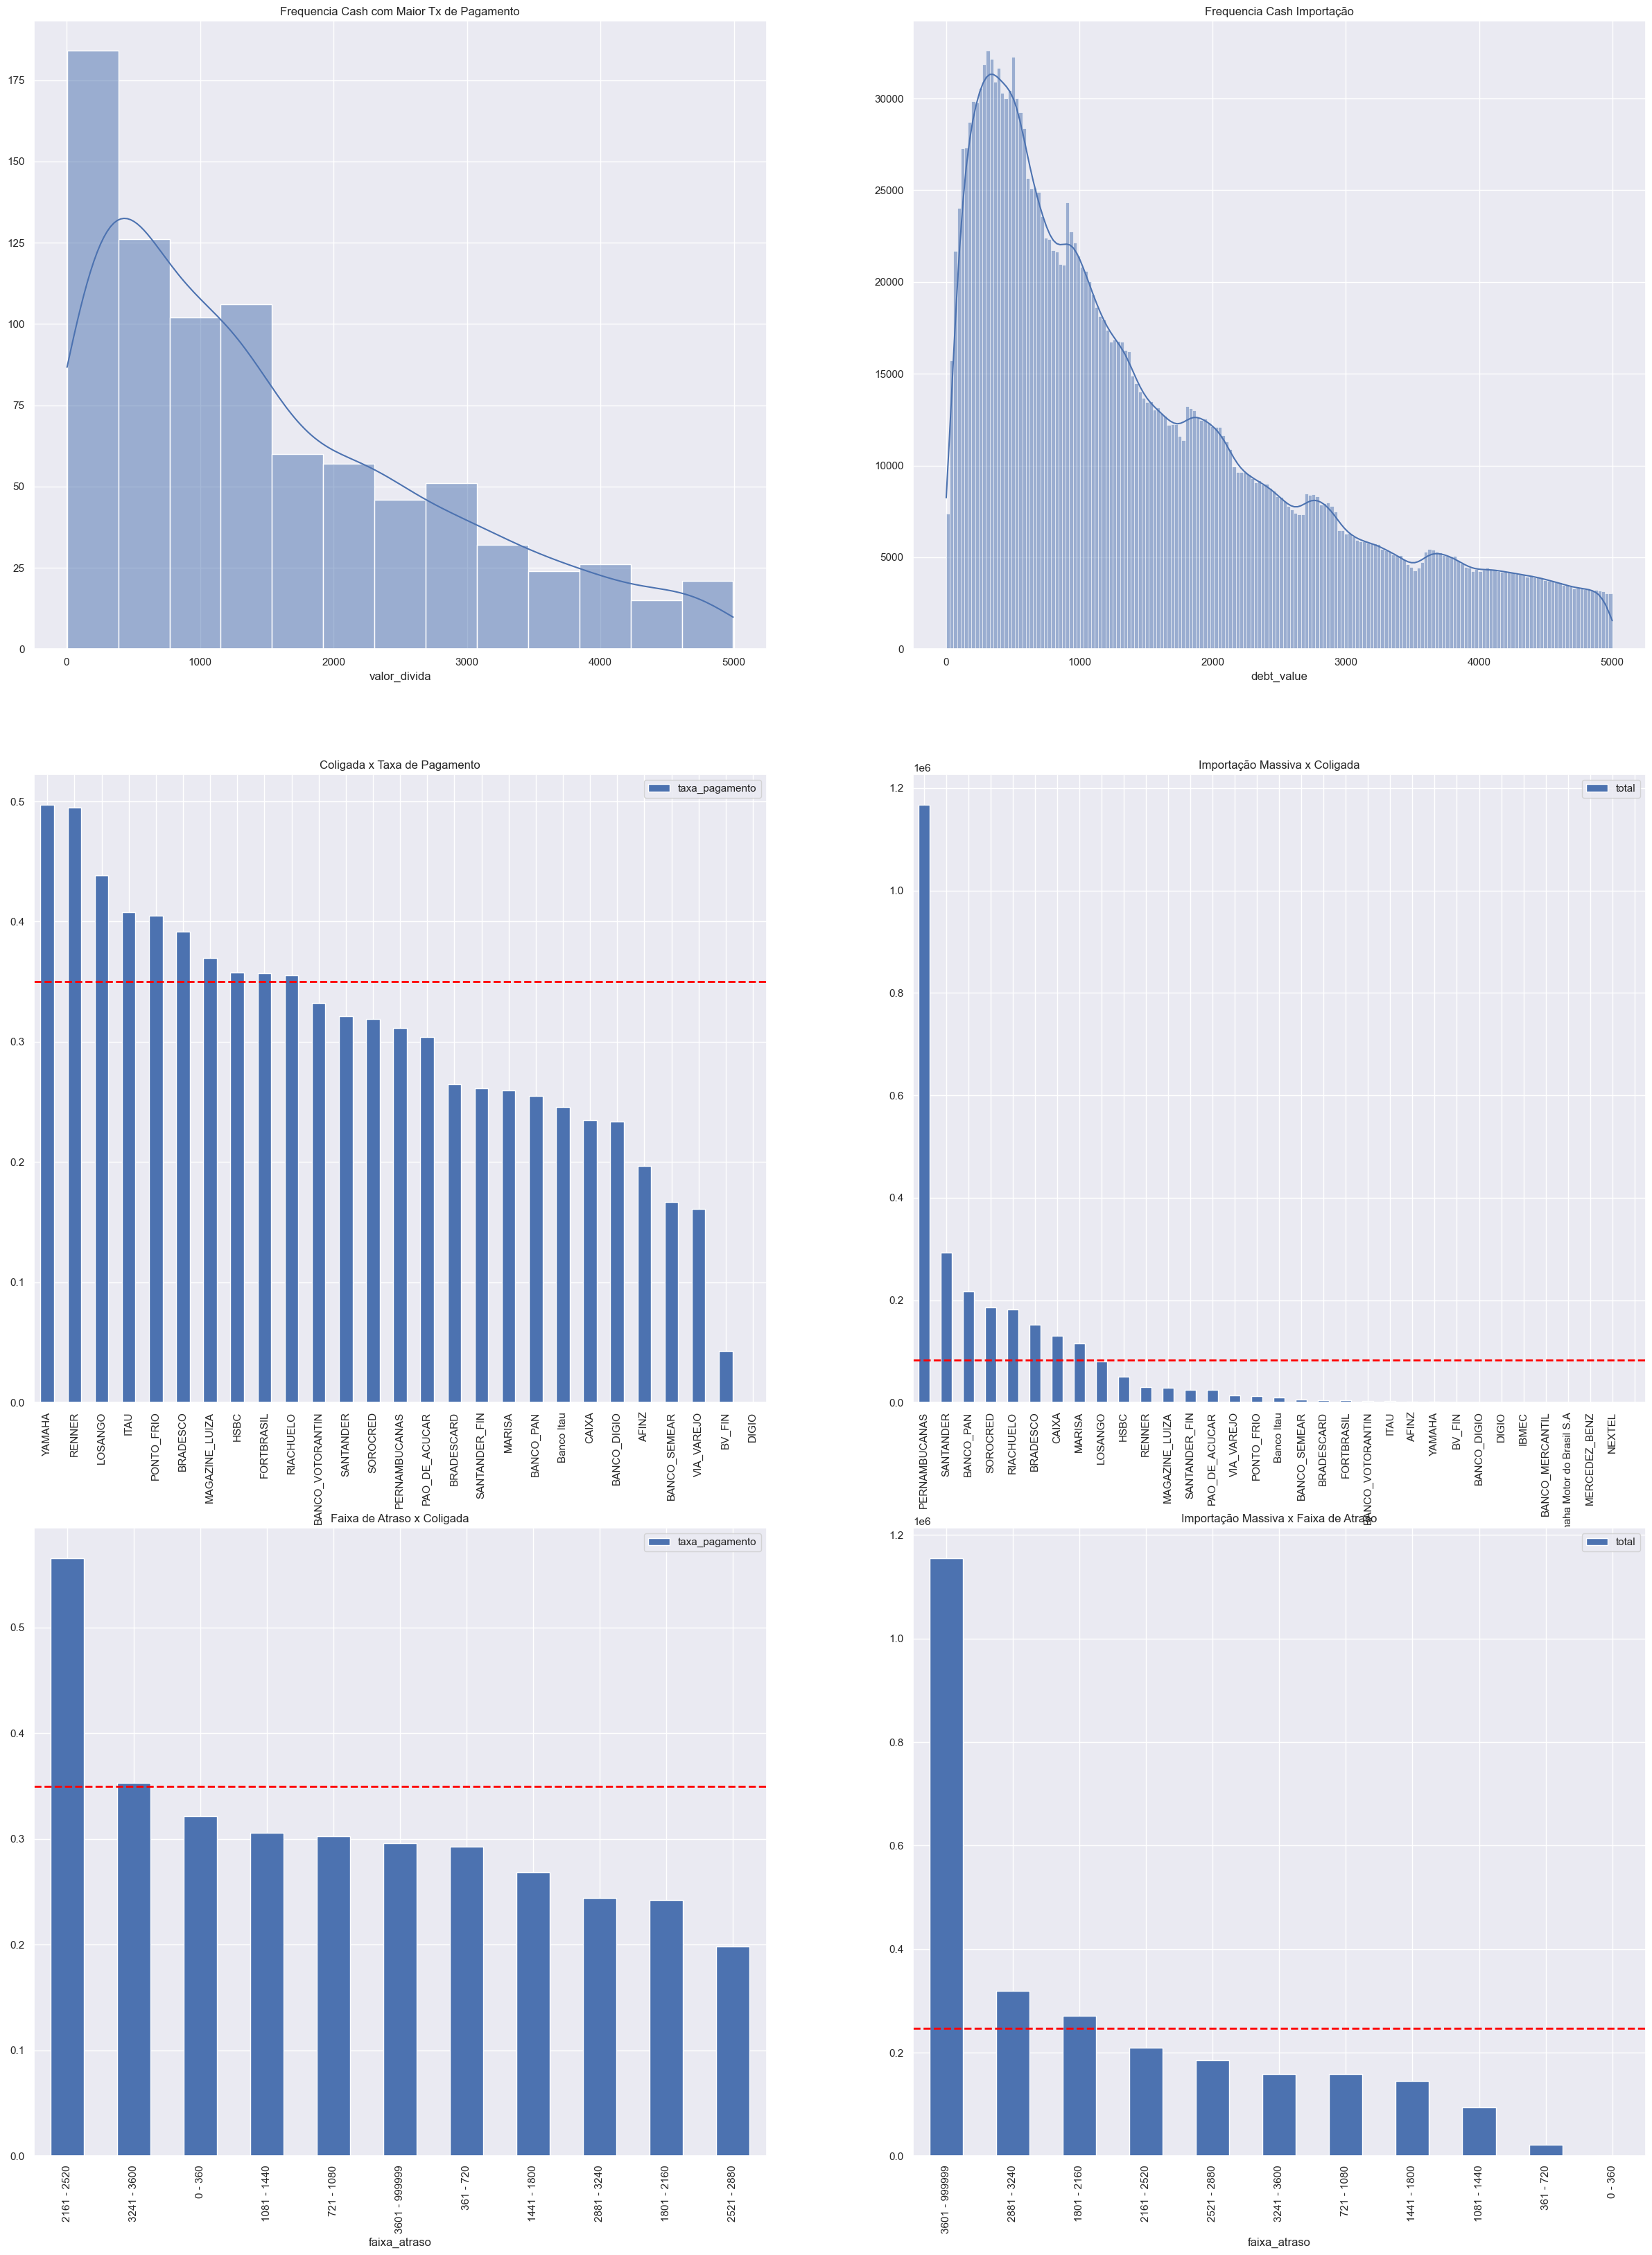

In [ ]:
fig, axes = plt.subplots(3,2, figsize=(30,40))
sns.histplot(valor_divida[valor_divida['valor_divida'] <= 5000]['valor_divida'], kde=True, ax= axes[0,0])
axes[0,0].set_title('Frequencia Cash com Maior Tx de Pagamento')
axes[0,0].set_ylabel('')
sns.histplot(valor_divida_importacao[valor_divida_importacao['debt_value'] <= 5000]['debt_value'], kde=True, ax= axes[0,1])
axes[0,1].set_title('Frequencia Cash Importação')
axes[0,1].set_ylabel('')
coligada.sort_values(by='taxa_pagamento', ascending=False).plot(kind='bar', x='segment', y='taxa_pagamento', ax= axes[1,0])
axes[1,0].axhline(0.35, color='red', linestyle='--', linewidth=2)
axes[1,0].set_title('Coligada x Taxa de Pagamento')
importacao_coligada.sort_values(by='total', ascending=False).plot(kind='bar', x='coligada', y='total', ax= axes[1,1])
axes[1,1].axhline(importacao_coligada['total'].mean(), color='red', linestyle='--', linewidth=2)
axes[1,1].set_title('Importação Massiva x Coligada')
FA_geral.sort_values(by='taxa_pagamento', ascending=False).plot(kind='bar', x='faixa_atraso', y='taxa_pagamento', ax= axes[2,0])
axes[2,0].axhline(0.35, color='red', linestyle='--', linewidth=2)
axes[2,0].set_title('Faixa de Atraso x Coligada')
importacao_faixa_atraso.sort_values(by='total', ascending=False).plot(kind='bar', x='faixa_atraso', y='total', ax= axes[2,1])
axes[2,1].axhline(importacao_faixa_atraso['total'].mean(), color='red', linestyle='--', linewidth=2)
axes[2,1].set_title('Importação Massiva x Faixa de Atraso');

In [78]:
base_exportar = ''' 
select
cu.customer_id,
cu.customer_document
from
	consolidacao_carteira.contact_10 c
join consolidacao_carteira.customer_10 cu on
	cu.customer_id = c.customer_id
join consolidacao_carteira.deal_10 d on
	d.deal_id = cu.best_deal_id
join quiteja_dados.dimensoes d2 on d.days_of_delay between coalesce(d2.de,0) and coalesce(d2.ate,999999) and d2.creditor_id = 10 and d2.tipo_cluster = 'Atraso' 
where
d.has_confirmed_proposal = false
and c.is_blacklist = false
and c.is_quarentine = false
and c.is_contact_notifiable = true
and cu.is_approachable = true
and d.allows_approaches = true
and d.allows_negotiation = true
and upper(d.segment) in ('YAMAHA','RENNER','LOSANGO','ITAU','PONTO_FRIO','BRADESCO','MAGAZINE_LUIZA',
'HSBC','FORTBRASIL','RIACHUELO','SANTANDER')
and d2.cod_cluster in (3, 7,10)
'''

In [79]:
importacao_massiva = sql_df(base_exportar)

In [91]:
importacao_massiva = importacao_massiva.drop_duplicates()

In [92]:
importacao_massiva.to_csv('base_importacao_massiva.csv', index=False)

## Modelo Serie Temporal 

In [34]:
maior_producao['taxa_pagamento'] = maior_producao['pagamentos'] / maior_producao['promessas']
maior_producao.head(5)

,total_producao,promessas,pagamentos,dia_mes,taxa_pagamento
created_at,,,,,
2023-01-01,5,553.2942,377.3234,1,0.681958
2023-01-02,171,27966.3128,12210.3237,2,0.436608
2023-01-03,302,40685.7349,16854.1668,3,0.414252
2023-01-04,318,58060.5279,13147.2193,4,0.226440
2023-01-05,367,90613.6025,22300.5347,5,0.246106


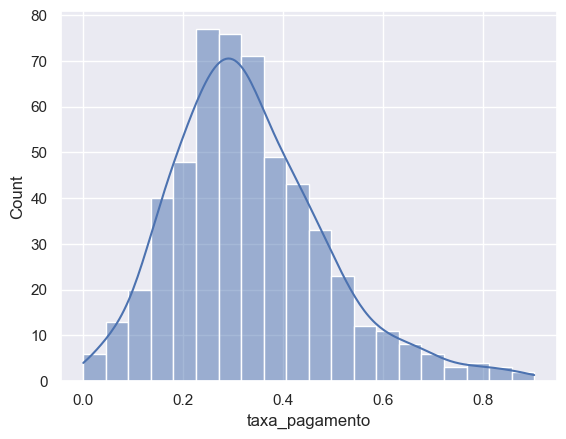

In [37]:
sns.histplot(maior_producao['taxa_pagamento'],kde=True);

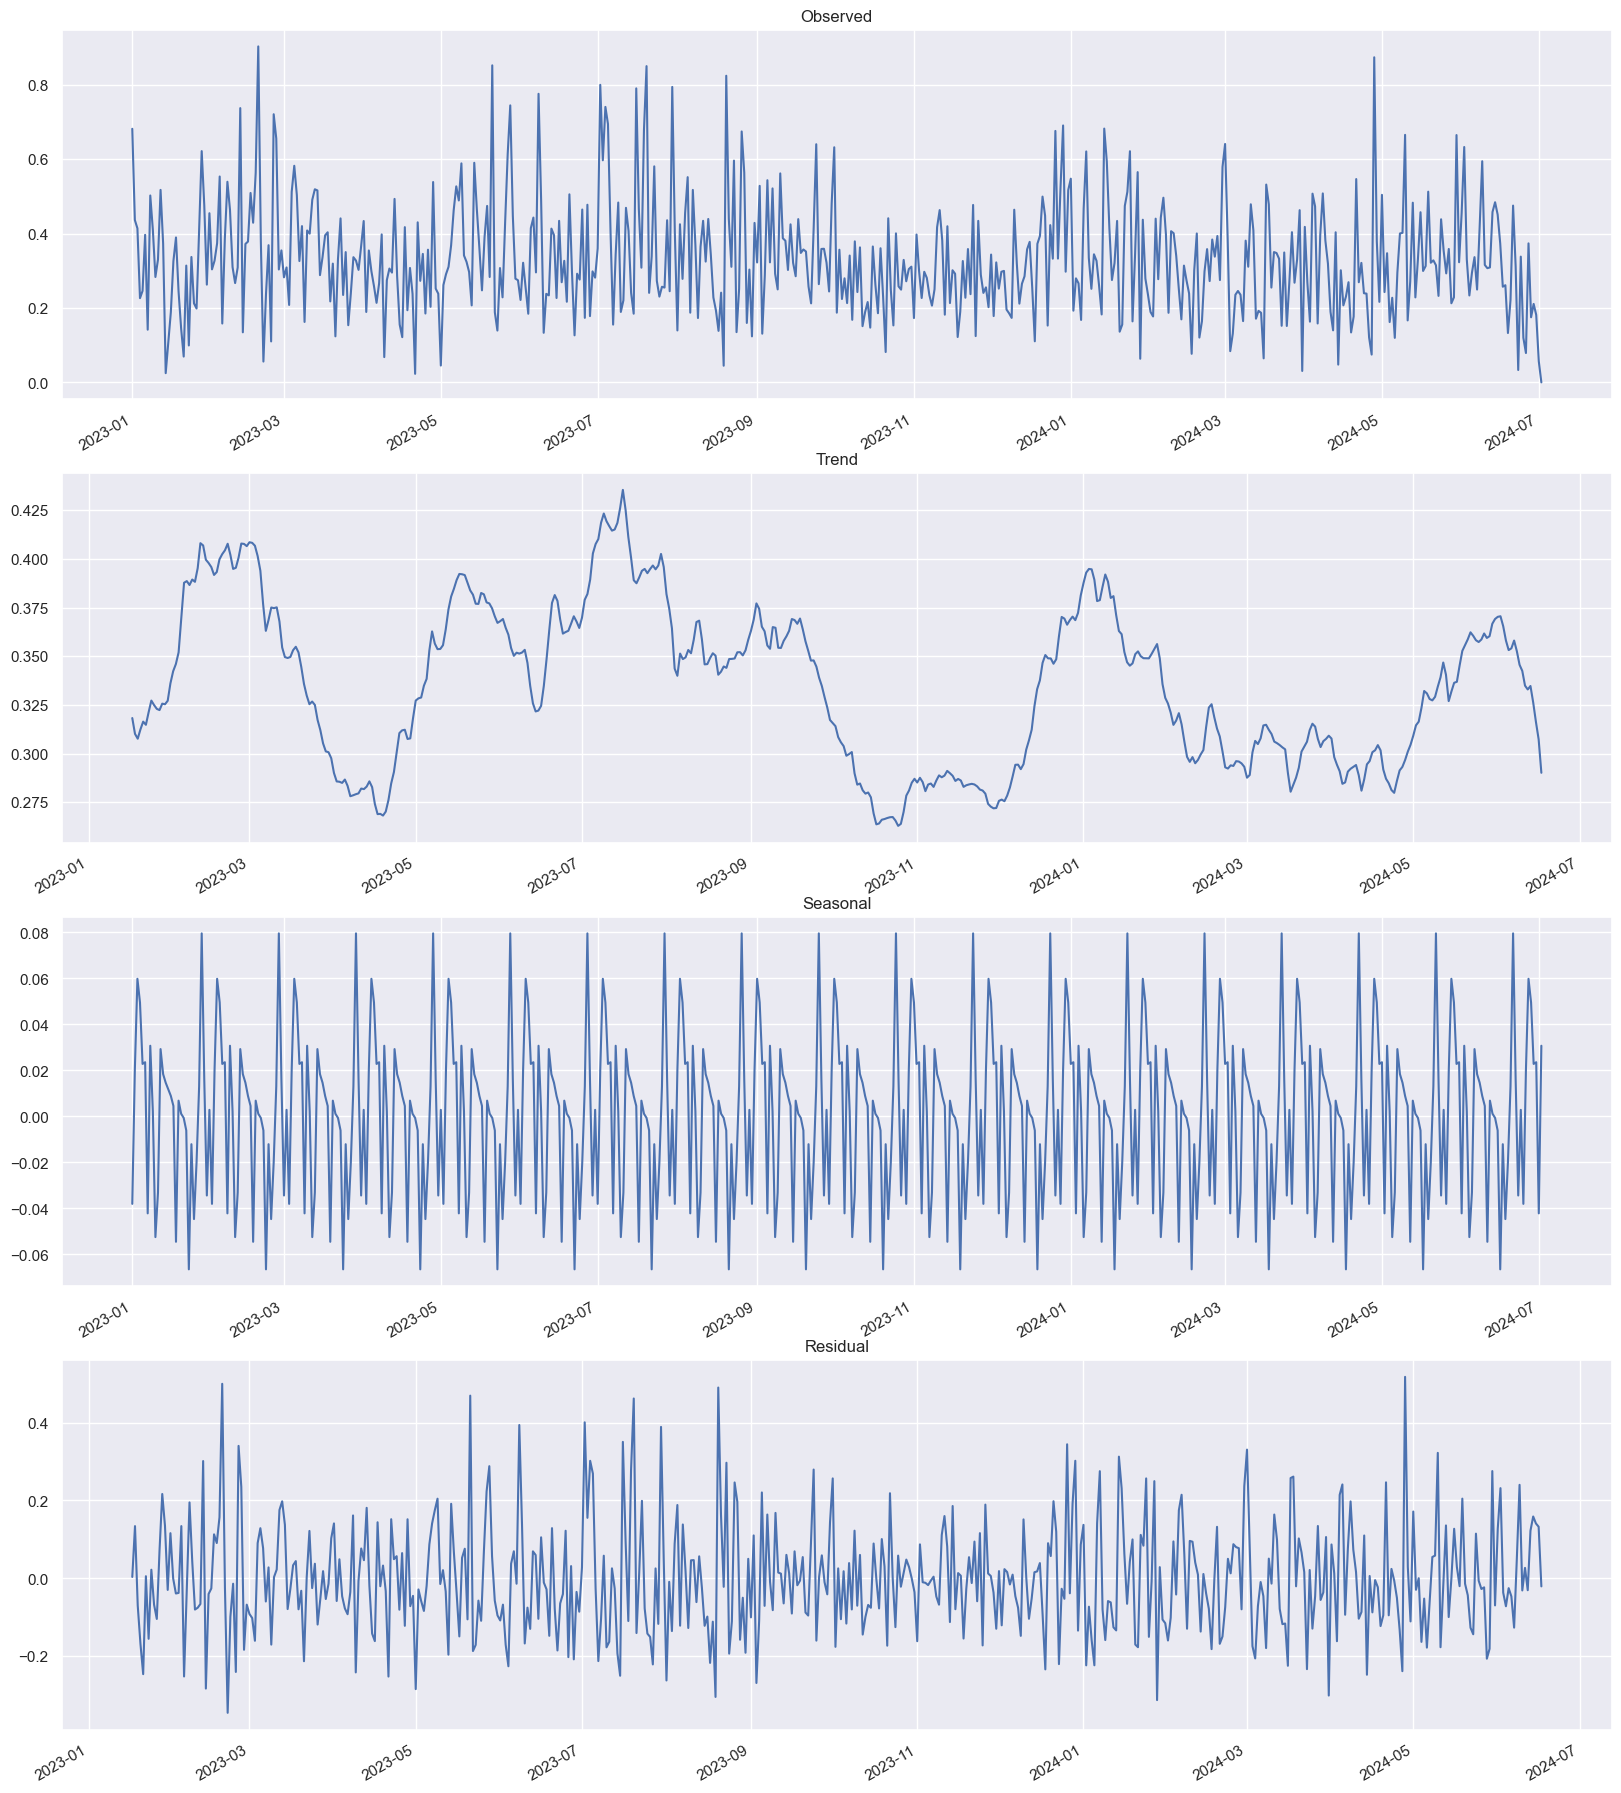

In [81]:
resultado = seasonal_decompose(maior_producao['taxa_pagamento'], model = 'add', period=30)

fig, axes = plt.subplots(4, 1, figsize=(20, 25))
resultado.observed.plot(ax=axes[0], legend=False, title='Observed')
axes[0].set_xlabel('')
resultado.trend.plot(ax=axes[1], legend=False, title='Trend')
axes[1].set_xlabel('')
resultado.seasonal.plot(ax=axes[2], legend=False, title='Seasonal')
axes[2].set_xlabel('')
resultado.resid.plot(ax=axes[3], legend=False, title='Residual')
axes[3].set_xlabel('');

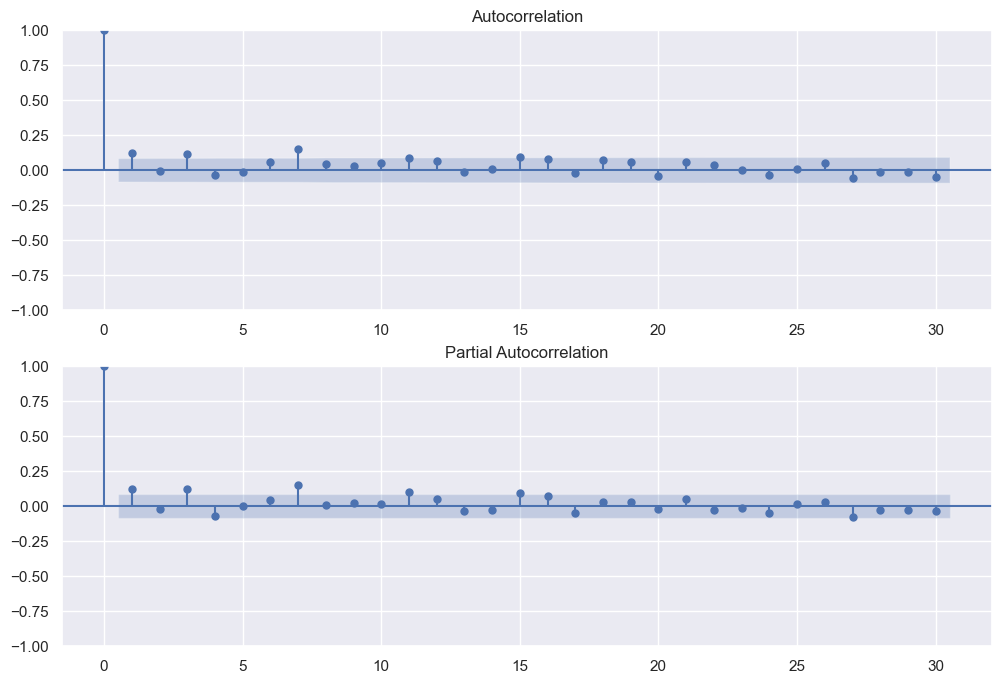

In [89]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plotar ACF e PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(maior_producao['taxa_pagamento'], lags=30, ax=ax1)
plot_pacf(maior_producao['taxa_pagamento'], lags=30, ax=ax2)
plt.show()

In [66]:
resultado = adfuller(maior_producao['taxa_pagamento'].dropna())

print(f'Teste ADF: {round(resultado[0],4)}')
print(f'P-Valor: {round(resultado[1],4)*100}%')

Teste ADF: -6.7001
P-Valor: 0.0%


In [90]:
fit_arima = auto_arima(maior_producao['taxa_pagamento'], d=1, start_p = 1, start_q=1, max_p=3, max_q=3,
                       seasonal = True,
                       m=7,
                       D=1,
                       start_P=1,
                       start_Q=1,
                       max_P = 2,
                       max_Q = 2,
                       information_criterion='aic',
                       trace=True,
                       error_action='ignore',
                       stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=inf, Time=1.00 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=126.758, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-81.915, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.44 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=6.753, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=-161.027, Time=0.31 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=0.98 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=0.50 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=-55.997, Time=0.12 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=-257.977, Time=0.30 sec
 ARIMA(2,1,0)(1,1,0)[7]             : AIC=-181.445, Time=0.17 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=inf, Time=2.35 sec
 ARIMA(2,1,0)(1,1,1)[7]             : AIC=inf, Time=0.99 sec
 ARIMA(3,1,0)(2,1,0)[7]             : AIC=-261.931, Time=0.41 sec
 ARIMA(3,1,0)(1,1,0)[7]             : AIC=-184.184, Time=0.22 sec
 AR

In [179]:
maior_producao

,total_producao,promessas,pagamentos,dia_mes,taxa_pagamento
created_at,,,,,
2023-01-01,5,553.2942,377.3234,1,0.681958
2023-01-02,171,27966.3128,12210.3237,2,0.436608
2023-01-03,302,40685.7349,16854.1668,3,0.414252
2023-01-04,318,58060.5279,13147.2193,4,0.226440
2023-01-05,367,90613.6025,22300.5347,5,0.246106
...,...,...,...,...,...
2024-06-28,46,17035.7400,2982.9000,28,0.175097
2024-06-29,31,4212.0600,888.7800,29,0.211008
2024-06-30,5,913.5600,165.7000,30,0.181378


In [188]:
# Separando variaveis X e Y

# X
sc_in = MinMaxScaler(feature_range=(0,1))
scaled_input = sc_in.fit_transform(maior_producao[['total_producao','promessas','pagamentos']])
scaled_input = pd.DataFrame(scaled_input)
x = scaled_input
x.rename(columns={0:'total_producao', 1:'promessas', 2:'pagamentos'}, inplace=True)
x.index = maior_producao.index
exog = np.array(x)

# Y

sc_in = MinMaxScaler(feature_range=(0,1))
scaled_output = sc_in.fit_transform(maior_producao[['taxa_pagamento']])
scaled_output = pd.DataFrame(scaled_output)
y = scaled_output
y.rename(columns={0:'taxa_pagamento'}, inplace=True)
y.index = maior_producao.index
endog = np.array(y)

In [216]:
sarima = SARIMAX(endog, order=(3,1,0), seasonal_order=(2,1,0,7), exog = exog,  enforce_invertibility=False, enforce_stationarity=False).fit()
MSE = (sarima.resid **2).mean()
MSE

0.025006209836673694

In [232]:
predicao = sarima.predict(start=0, end=len(y)-1, exog=x)
predicao

array([ 0.00262564,  0.48370629,  0.36240773,  0.2415893 ,  0.1627042 ,
        0.60631198,  0.55561387,  0.74908821,  0.50936006,  0.40570035,
        0.41055607,  0.57994032,  0.30794958,  0.0635631 ,  0.24095881,
        0.28720198,  0.34050536,  0.22868026,  0.16643842,  0.40186126,
       -0.0659823 ,  0.12893823,  0.35183212,  0.38488604,  0.22295481,
        0.56029212,  0.28246027,  0.29689482,  0.48991676,  0.56870144,
        0.39966847,  0.38423283,  0.41936036,  0.57129765,  0.35309569,
        0.30181476,  0.57995748,  0.46355931,  0.37138435,  0.40193897,
        0.3960477 ,  0.31883016,  0.33710181,  0.51463416,  0.52864382,
        0.57438396,  0.50614666,  0.52761842,  0.66524412,  0.53271138,
        0.56439061,  0.44164711,  0.35801105, -0.30716699,  0.62159759,
        0.72586485,  0.44333754,  0.31060427,  0.3608151 ,  0.40696729,
        0.29048164,  0.59735962,  0.81250566,  0.46495721,  0.24734891,
        0.34258512,  0.03592136,  0.55460175,  0.68693394,  0.79

Aqui é possível observar que os clientes tem tendência a fechar proposta uma semana antes da data de vencimento. O segundo melhor dia de produção é o dia anterior ao vencimento. 

Para depois do almoço 

- Abrir por faixas - OK
- Ver a relação dos dias com maior taxa de pagamento que dia que foi feito a proposta Ok
- Ver dos dias com maior produção, qual possui a maior taxa de pagamento
Após essas análises verificar 

- Regressão para entender quais variaveis que mais impactam  na taxa de atraso

# Colchão

In [233]:
query_tx_pagamento = ''' 
select
payment.due_date::date dia, 
sum(value)::float vencimentos_volume,
sum(case when payment.status = 'PAYED' then value end)::float pagamentos_volume,
case when sum(case when payment.status = 'PAYED' then value end) = 0 or sum(value) = 0 then 0 else
sum(case when payment.status = 'PAYED' then value end)/sum(value)::float end as tx_pagamento_volume
from quiteja_lake.payment
left join quiteja_dados.ajuste_payment ap on ap.deal_id = payment.deal_id and ap.installment_number = payment.installment_number  
join kpi.credores on credores.creditor_id = payment.creditor_id
join quiteja_lake.deal on deal.id = payment.deal_id
left join quiteja_lake.operation o on payment.deal_id = o.id and o.active is true 
where 1=1
and "quiteja_lake"."payment"."creditor_id" = 10
and CAST("quiteja_lake"."payment"."due_date" AS date) BETWEEN date '2024-01-01'
   AND date '2024-12-31'
and (ap.new_status in ('EXPIRED','PENDING') or (ap.new_status is null and payment.status not in ('DISCARTED')))
and payment.type = 'INSTALLMENT'
and date(payment.due_date) < current_date
group by 1 
order by 1


'''

In [234]:
tx_pagamento = sql_df(query_tx_pagamento)
tx_pagamento['dia'] = pd.to_datetime(tx_pagamento['dia'])
tx_pagamento['dia_mes'] = tx_pagamento['dia'].dt.day
tx_pagamento = tx_pagamento.set_index(tx_pagamento['dia'])

<Axes: xlabel='dia'>

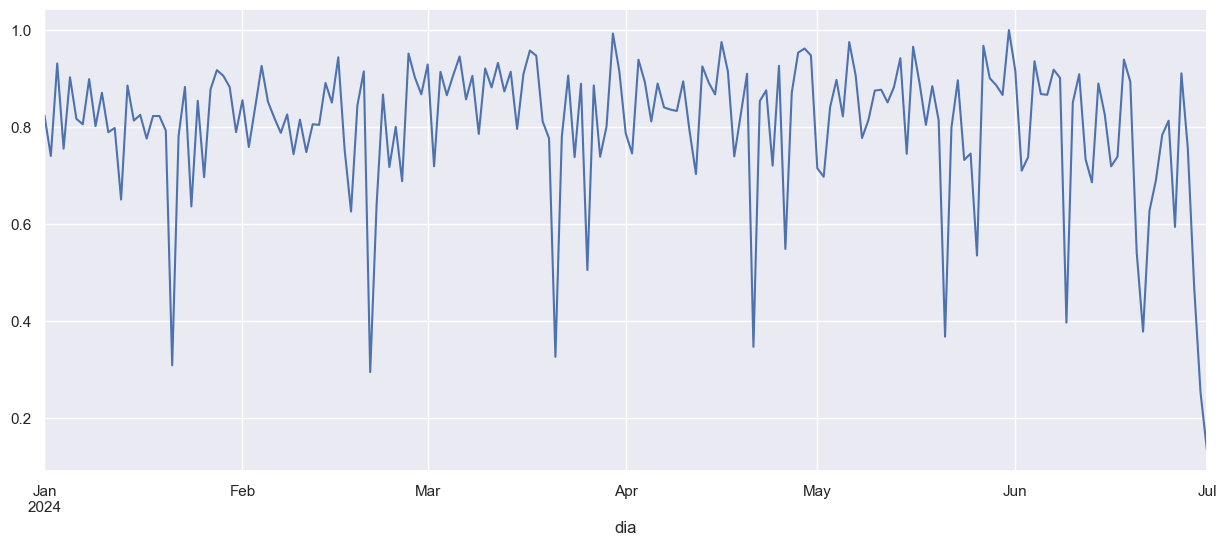

In [235]:
plt.figure(figsize=(15,6))
tx_pagamento['tx_pagamento_volume'].plot()

<Axes: xlabel='dia'>

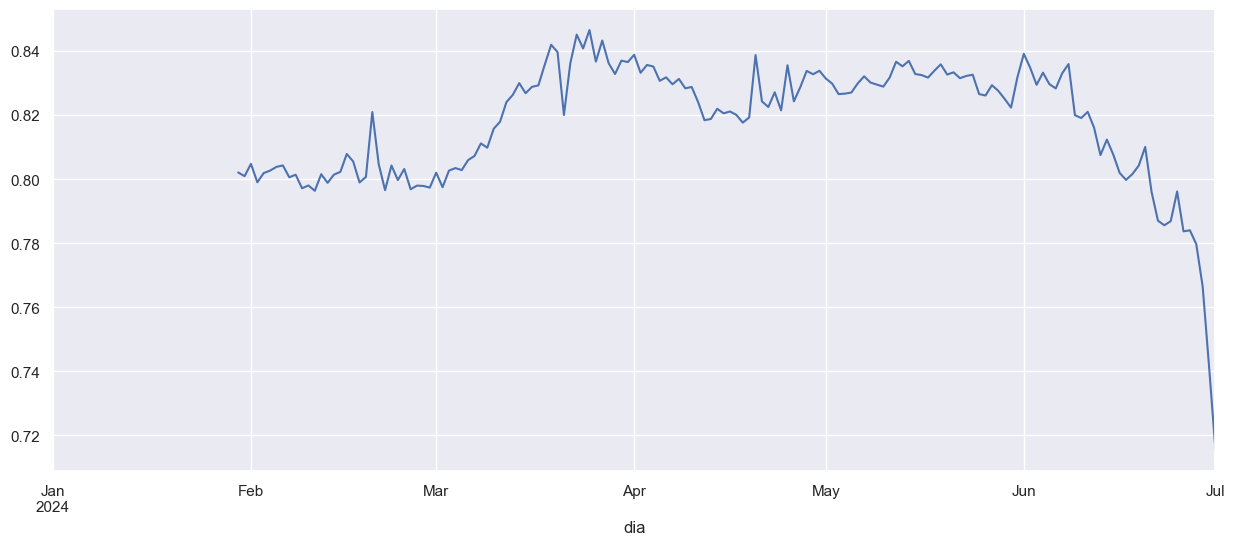

In [236]:
tx_pagamento['tx_pagamento_volume'].rolling(30).mean().plot(figsize=(15,6))

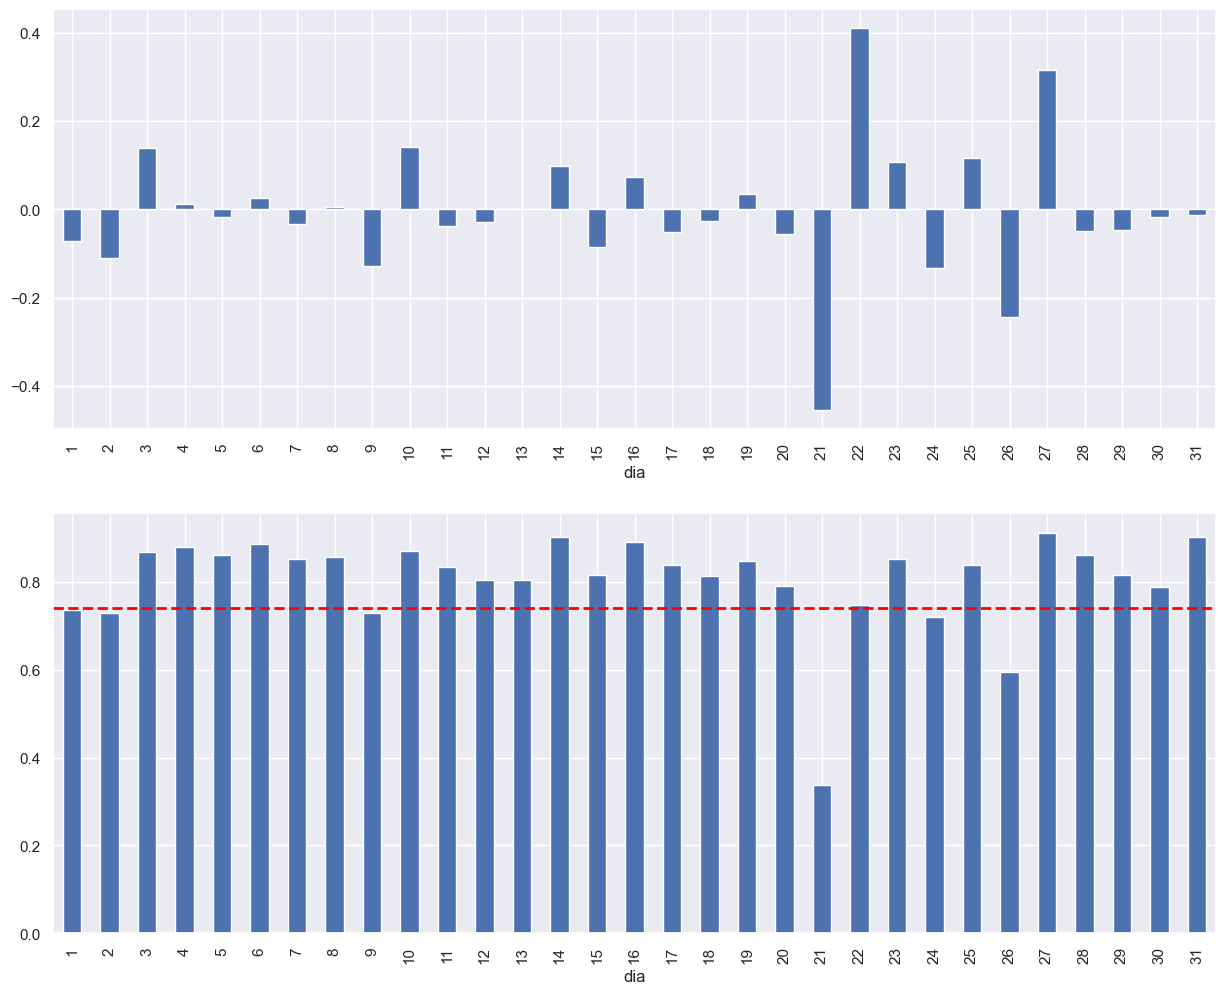

In [199]:
fig, axs = plt.subplots(2, 1, figsize=(15,12))
tx_pagamento['tx_pagamento_volume'].diff().groupby(tx_pagamento.index.day).mean().plot(kind='bar', ax=axs[0])
tx_pagamento['tx_pagamento_volume'].groupby(tx_pagamento.index.day).mean().plot(kind='bar',ax=axs[1])
plt.axhline(0.74, color='red', linestyle='--', linewidth=2)

In [200]:
# Top 10 dias com maior taxa de pagamento 

tx_pagamento['tx_pagamento_volume'].groupby(tx_pagamento.index.day).mean().sort_values(ascending = False).head(10)

dia
27    0.910639
14    0.902215
31    0.901516
16    0.889660
6     0.885353
4     0.878683
10    0.871031
3     0.867293
28    0.861380
5     0.860376
Name: tx_pagamento_volume, dtype: float64

In [201]:
query_faixa_atraso = ''' 
select
payment.due_date::date dia, 
dim.cod_cluster,
coalesce(dim.de,0) || ' - ' || coalesce(dim.ate,999999) faixa_atraso,
sum(value)::float vencimentos_volume,
sum(case when payment.status = 'PAYED' then value end)::float pagamentos_volume,
case when sum(case when payment.status = 'PAYED' then value end) = 0 or sum(value) = 0 then 0 else
sum(case when payment.status = 'PAYED' then value end)/sum(value)::float end as tx_pagamento_volume
from quiteja_lake.payment
left join quiteja_dados.ajuste_payment ap on ap.deal_id = payment.deal_id and ap.installment_number = payment.installment_number  
join kpi.credores on credores.creditor_id = payment.creditor_id
join quiteja_lake.deal on deal.id = payment.deal_id
left join quiteja_lake.operation o on payment.deal_id = o.id and o.active is true 
join quiteja_dados.dimensoes dim on o.days_of_delay between coalesce(dim.de,0) and coalesce(dim.ate, 999999) and dim.creditor_id = 10 and tipo_cluster = 'Atraso'
where 1=1
and "quiteja_lake"."payment"."creditor_id" = 10
and CAST("quiteja_lake"."payment"."due_date" AS date) BETWEEN date '2024-01-01'
   AND date '2024-12-31'
and (ap.new_status in ('EXPIRED','PENDING') or (ap.new_status is null and payment.status not in ('DISCARTED')))
and payment.type = 'INSTALLMENT'
and date(payment.due_date) < current_date
group by 1, 2, 3 
order by 1, 2 '''


query_FA_filtred = ''' 
select
payment.due_date::date dia, 
dim.cod_cluster,
coalesce(dim.de,0) || ' - ' || coalesce(dim.ate,999999) faixa_atraso,
sum(value)::float vencimentos_volume,
sum(case when payment.status = 'PAYED' then value end)::float pagamentos_volume,
case when sum(case when payment.status = 'PAYED' then value end) = 0 or sum(value) = 0 then 0 else
sum(case when payment.status = 'PAYED' then value end)/sum(value)::float end as tx_pagamento_volume
from quiteja_lake.payment
left join quiteja_dados.ajuste_payment ap on ap.deal_id = payment.deal_id and ap.installment_number = payment.installment_number  
join kpi.credores on credores.creditor_id = payment.creditor_id
join quiteja_lake.deal on deal.id = payment.deal_id
left join quiteja_lake.operation o on payment.deal_id = o.id and o.active is true 
join quiteja_dados.dimensoes dim on o.days_of_delay between coalesce(dim.de,0) and coalesce(dim.ate, 999999) and dim.creditor_id = 10 and tipo_cluster = 'Atraso'
where 1=1
and "quiteja_lake"."payment"."creditor_id" = 10
and CAST("quiteja_lake"."payment"."due_date" AS date) BETWEEN date '2024-01-01'
   AND date '2024-12-31'
and (ap.new_status in ('EXPIRED','PENDING') or (ap.new_status is null and payment.status not in ('DISCARTED')))
and payment.type = 'INSTALLMENT'
and date(payment.due_date) < current_date
and cod_cluster in (4,10)
group by 1, 2, 3 
order by 1, 2 

'''

In [202]:
FA_geral = sql_df(query_faixa_atraso)
FA_geral['dia'] = pd.to_datetime(FA_geral['dia'])
FA_geral['dia_mes'] = FA_geral['dia'].dt.day
FA_geral = FA_geral.set_index(FA_geral['dia'])
FA_geral = FA_geral[['vencimentos_volume','pagamentos_volume']].groupby(by = FA_geral['faixa_atraso']).mean().reset_index()
FA_geral['taxa_pagamento'] = FA_geral['pagamentos_volume'] / FA_geral['vencimentos_volume']

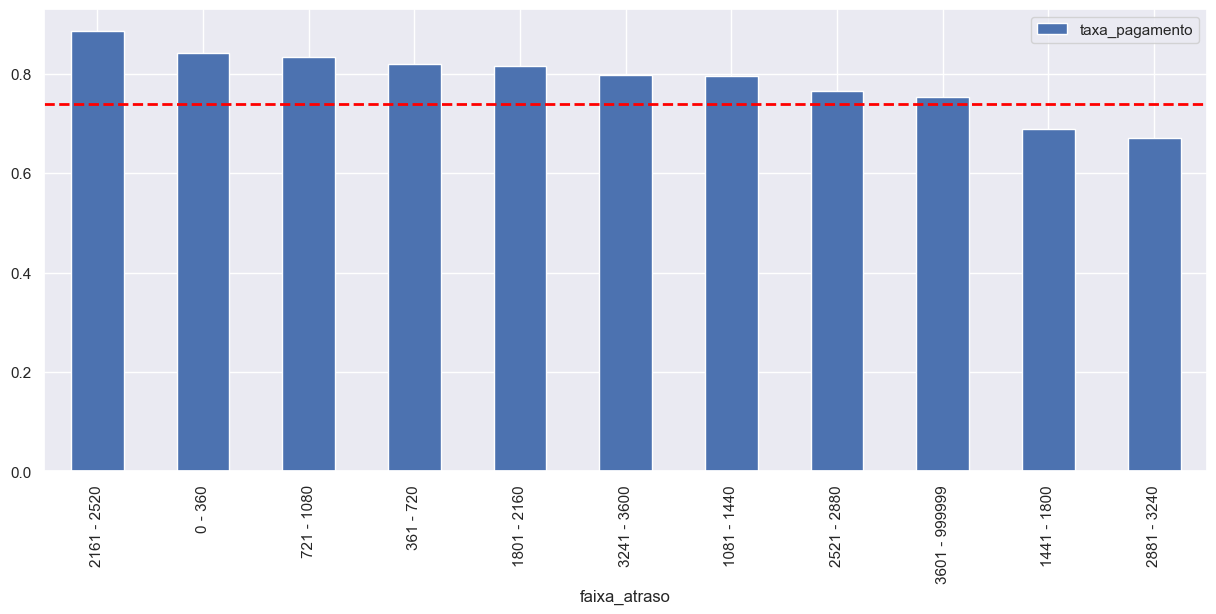

In [203]:
FA_geral.sort_values(by='taxa_pagamento', ascending=False).plot(kind='bar', x='faixa_atraso', y='taxa_pagamento', figsize=(15,6))
plt.axhline(0.74, color='red', linestyle='--', linewidth=2)

In [204]:
faixa_atraso = sql_df(query_FA_filtred)
faixa_atraso['dia'] = pd.to_datetime(faixa_atraso['dia'])
faixa_atraso['dia_mes'] = faixa_atraso['dia'].dt.day
faixa_atraso = faixa_atraso.set_index(faixa_atraso['dia'])

In [205]:
faixa_atraso = faixa_atraso[['vencimentos_volume','pagamentos_volume']].groupby(by = [faixa_atraso.index.day, faixa_atraso['faixa_atraso']]).mean().reset_index()

In [206]:
faixa_atraso['taxa_pagamento'] = faixa_atraso['pagamentos_volume'] / faixa_atraso['vencimentos_volume']

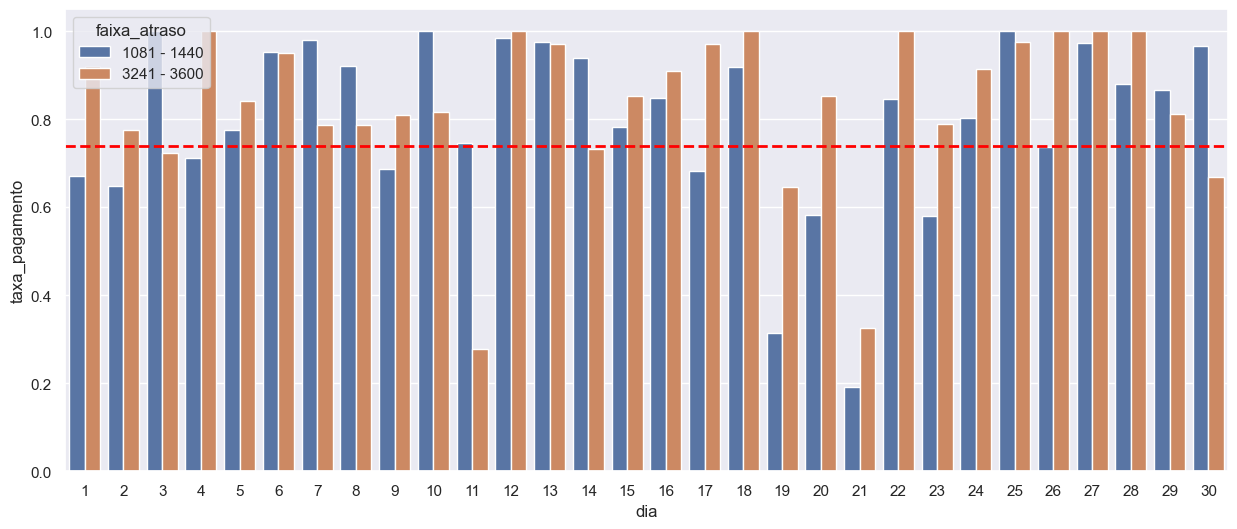

In [207]:
plt.figure(figsize=(15,6))
sns.barplot(faixa_atraso, x='dia', y='taxa_pagamento', hue='faixa_atraso')
plt.axhline(0.74, color='red', linestyle='--', linewidth=2)

As datas de vencimento com melhor taxa de pagamento, de acordo com o desempenho geral e as melhores faixas de atraso, é o dia 5, 8, 17, 25.

A fim de entender qual dia vale apena mais estimulos, irei entender qual dia que as deals referente a essas datas de vencimento, foram produzidas. 

## Propostas

In [208]:
query_producao = ''' 
select
payment.due_date::date dia_vencimento, 
p.agreed_at::date dia_producao,
count(payment.deal_id)
from quiteja_lake.payment
left join quiteja_dados.ajuste_payment ap on ap.deal_id = payment.deal_id and ap.installment_number = payment.installment_number  
join kpi.credores on credores.creditor_id = payment.creditor_id
join quiteja_lake.deal on deal.id = payment.deal_id
--left join quiteja_lake.operation o on payment.deal_id = o.id and o.active is true 
join quiteja_lake.proposal p on p.deal_id = payment.deal_id and p.status = 'AGREED'
where 1=1
and "quiteja_lake"."payment"."creditor_id" = 10
and CAST("quiteja_lake"."payment"."due_date" AS date) BETWEEN date '2024-01-01'
   AND date '2024-12-31'
and (ap.new_status in ('EXPIRED','PENDING') or (ap.new_status is null and payment.status not in ('DISCARTED')))
and payment.type = 'INSTALLMENT'
and date_part('day',payment.due_date) in (5, 8, 17, 25)
group by 1, 2
order by 1
'''

In [209]:
producao = sql_df(query_producao)
producao['dia_vencimento'] = pd.to_datetime(producao['dia_vencimento'])
producao['dia_vencimento'] = producao['dia_vencimento'].dt.day
producao['dia_producao'] = pd.to_datetime(producao['dia_producao'])
producao['dia_producao'] = producao['dia_producao'].dt.day

In [210]:
producao[producao['dia_vencimento'] == 5]['count'].groupby(by=producao['dia_producao']).mean().sort_values(ascending=False)

dia_producao
28    5.365385
27    5.230769
4     3.736111
29    2.714286
5     2.090909
1     1.750000
30    1.419355
2     1.277778
3     1.000000
31    1.000000
Name: count, dtype: float64

Text(0.5, 0, '')

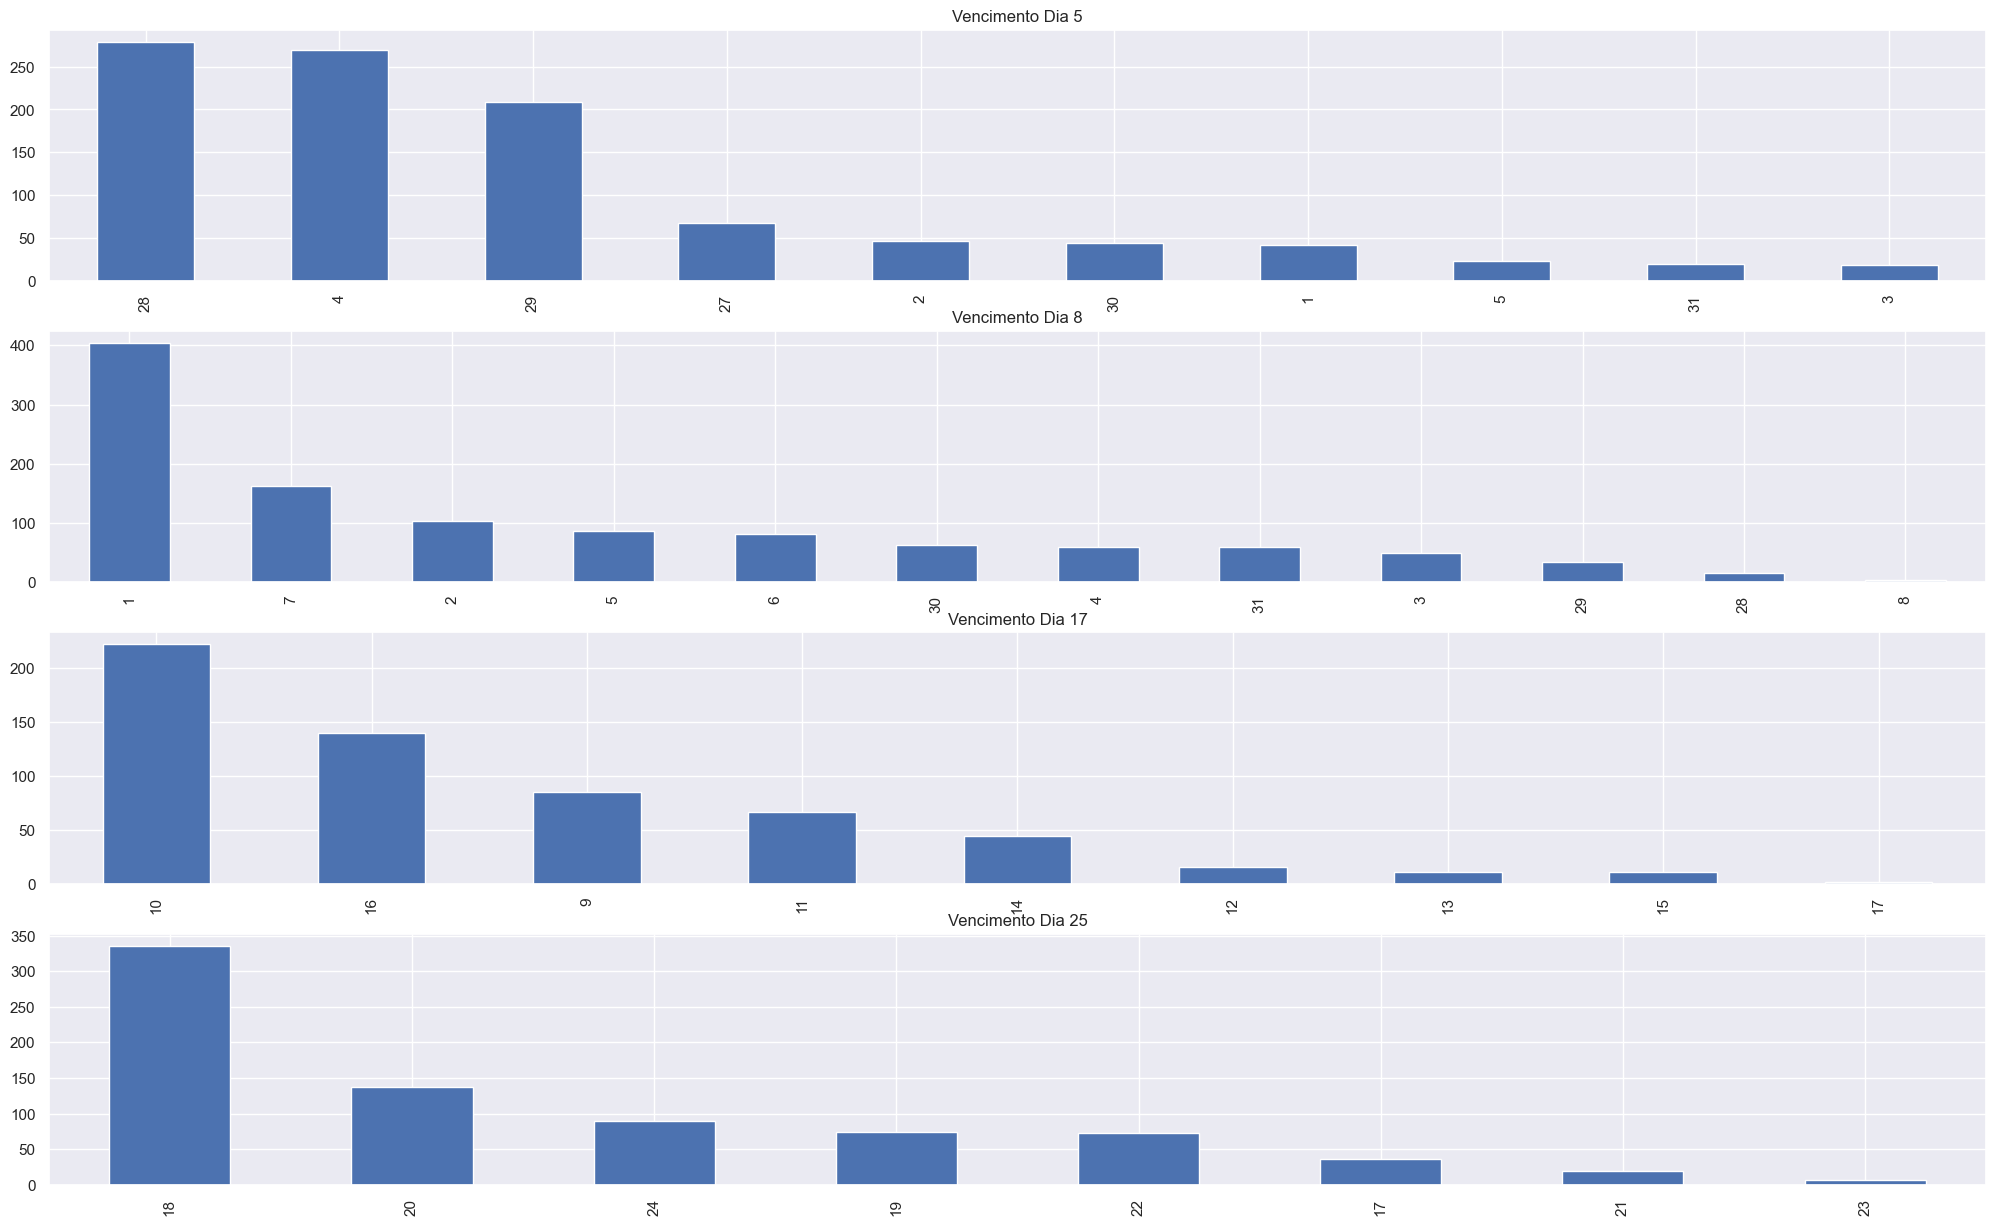

In [211]:
fig, axs = plt.subplots(4,1, figsize=(25,15))
producao[producao['dia_vencimento'] == 5]['count'].groupby(by=producao['dia_producao']).sum().sort_values(ascending=False).plot(kind='bar', ax= axs[0], title='Vencimento Dia 5')
axs[0].set_xlabel('')
producao[producao['dia_vencimento'] == 8]['count'].groupby(by=producao['dia_producao']).sum().sort_values(ascending=False).plot(kind='bar', ax= axs[1], title='Vencimento Dia 8')
axs[1].set_xlabel('')
producao[producao['dia_vencimento'] == 17]['count'].groupby(by=producao['dia_producao']).sum().sort_values(ascending=False).plot(kind='bar', ax= axs[2], title='Vencimento Dia 17')
axs[2].set_xlabel('')
producao[producao['dia_vencimento'] == 25]['count'].groupby(by=producao['dia_producao']).sum().sort_values(ascending=False).plot(kind='bar', ax= axs[3], title='Vencimento Dia 25')
axs[3].set_xlabel('')

Text(0.5, 0, '')

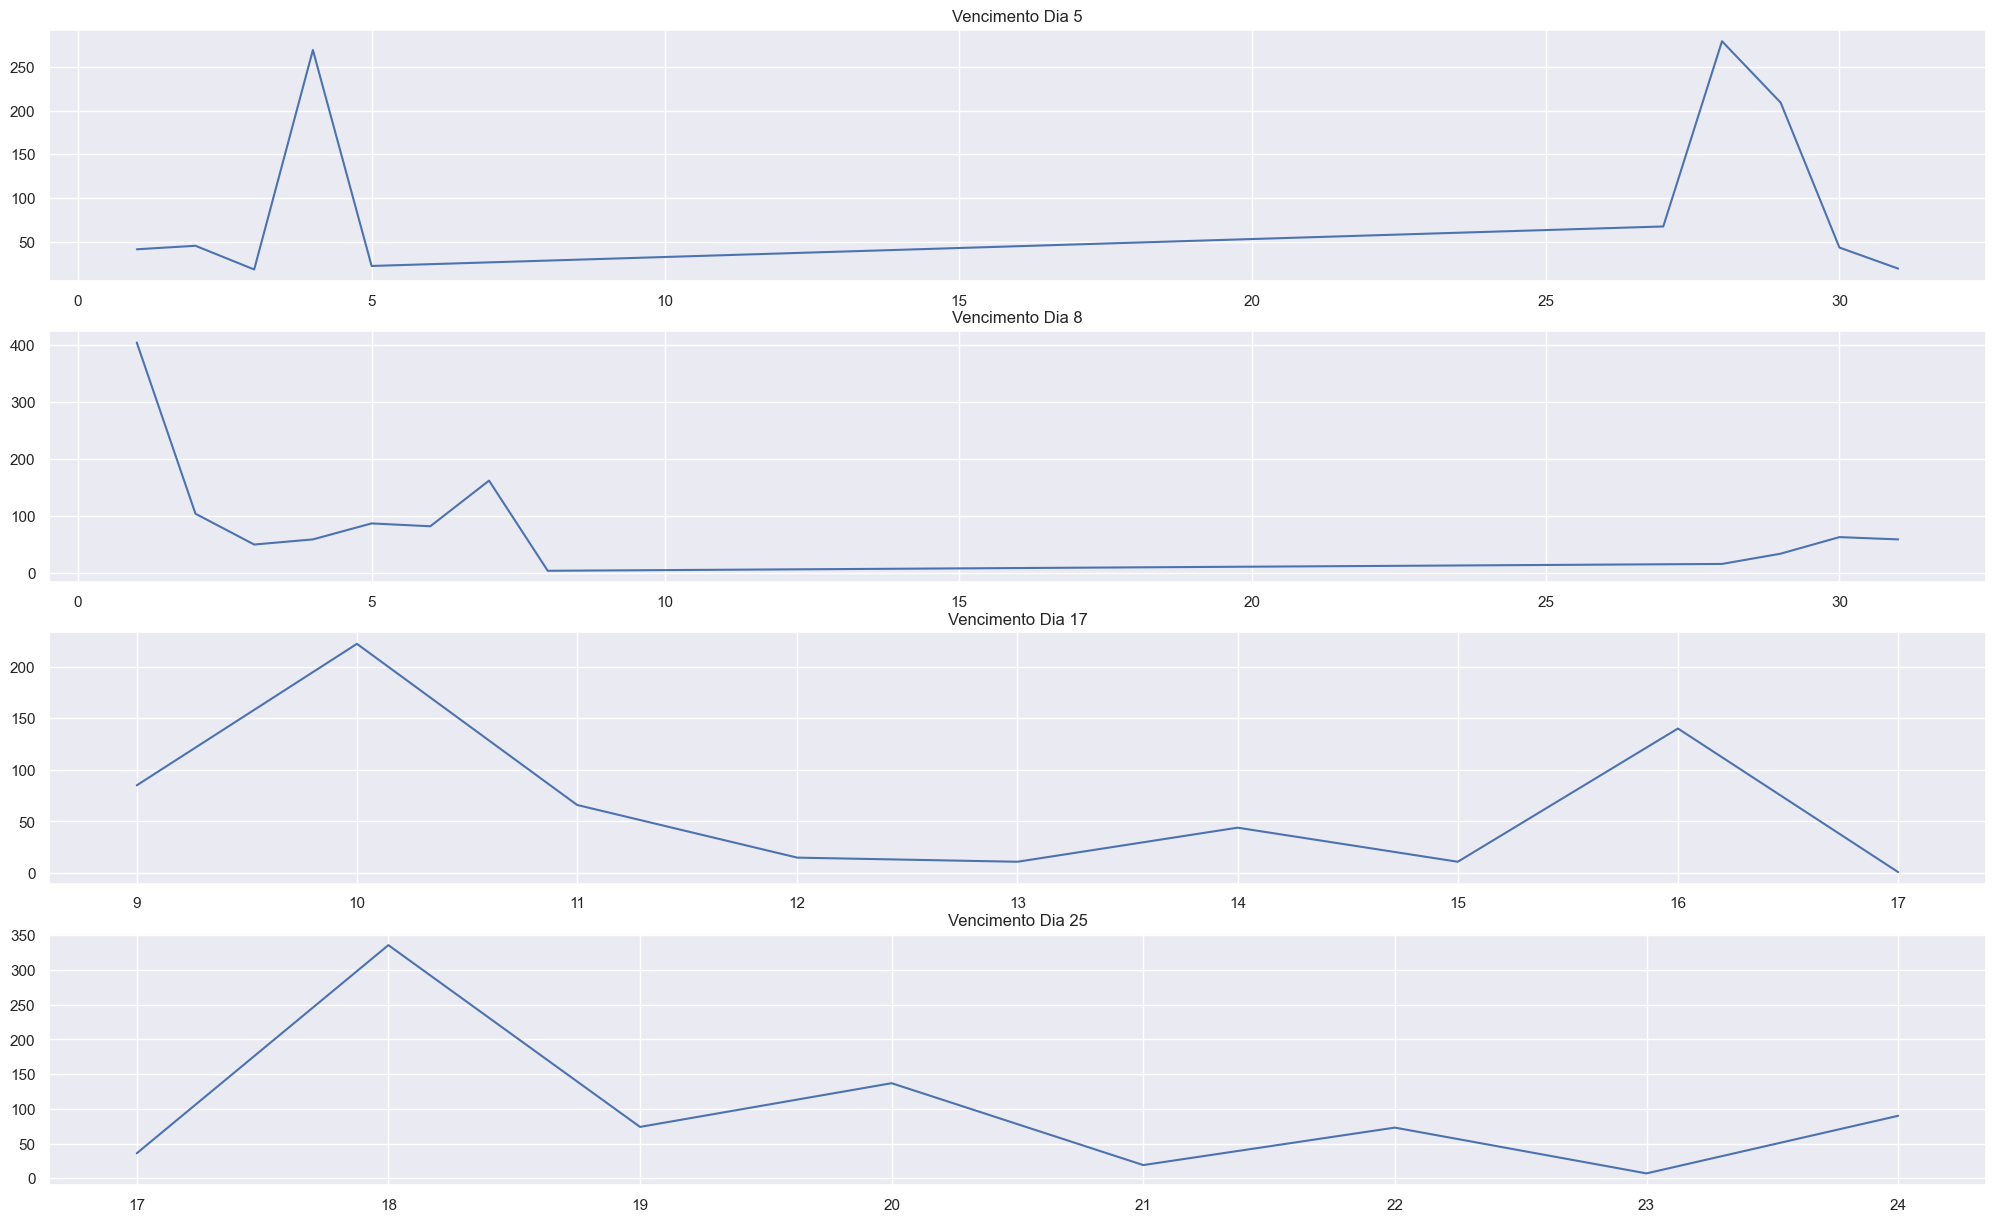

In [212]:
fig, axs = plt.subplots(4,1, figsize=(25,15))
producao[producao['dia_vencimento'] == 5]['count'].groupby(by=producao['dia_producao']).sum().plot(ax= axs[0], title='Vencimento Dia 5')
axs[0].set_xlabel('')
producao[producao['dia_vencimento'] == 8]['count'].groupby(by=producao['dia_producao']).sum().plot(ax= axs[1], title='Vencimento Dia 8')
axs[1].set_xlabel('')
producao[producao['dia_vencimento'] == 17]['count'].groupby(by=producao['dia_producao']).sum().plot(ax= axs[2], title='Vencimento Dia 17')
axs[2].set_xlabel('')
producao[producao['dia_vencimento'] == 25]['count'].groupby(by=producao['dia_producao']).sum().plot(ax= axs[3], title='Vencimento Dia 25')
axs[3].set_xlabel('')

In [213]:
query_producao_fa = ''' 
select
payment.due_date::date dia_vencimento, 
dim.cod_cluster,
coalesce(dim.de,0) || ' - ' || coalesce(dim.ate,999999) faixa_atraso,
p.agreed_at::date dia_producao,
count(payment.deal_id)
from quiteja_lake.payment
left join quiteja_dados.ajuste_payment ap on ap.deal_id = payment.deal_id and ap.installment_number = payment.installment_number  
join kpi.credores on credores.creditor_id = payment.creditor_id
join quiteja_lake.deal on deal.id = payment.deal_id
left join quiteja_lake.operation o on payment.deal_id = o.id and o.active is true 
join quiteja_dados.dimensoes dim on o.days_of_delay between coalesce(dim.de,0) and coalesce(dim.ate, 999999) and dim.creditor_id = 10 and tipo_cluster = 'Atraso'
join quiteja_lake.proposal p on p.deal_id = payment.deal_id and p.status = 'AGREED'
where 1=1
and "quiteja_lake"."payment"."creditor_id" = 10
and CAST("quiteja_lake"."payment"."due_date" AS date) BETWEEN date '2024-01-01'
   AND date '2024-12-31'
and (ap.new_status in ('EXPIRED','PENDING') or (ap.new_status is null and payment.status not in ('DISCARTED')))
and payment.type = 'INSTALLMENT'
and date_part('day',payment.due_date) in (5, 8, 17, 25)
and cod_cluster in (4,10)
group by 1, 2, 3,4
order by 1,2
'''

In [214]:
producao_fa = sql_df(query_producao_fa)
producao_fa['dia_vencimento'] = pd.to_datetime(producao_fa['dia_vencimento'])
producao_fa['dia_vencimento'] = producao_fa['dia_vencimento'].dt.day
producao_fa['dia_producao'] = pd.to_datetime(producao_fa['dia_producao'])
producao_fa['dia_producao'] = producao_fa['dia_producao'].dt.day

In [215]:
producao_fa[producao_fa['dia_vencimento'] == 5]['count'].groupby(by=[producao_fa['dia_producao'],producao_fa['faixa_atraso']]).sum().unstack().fillna(0)

faixa_atraso,1081 - 1440,3241 - 3600
dia_producao,,
4,15.0,10.0
5,1.0,0.0
27,2.0,0.0
28,5.0,20.0
30,16.0,0.0


Text(0.5, 0, '')

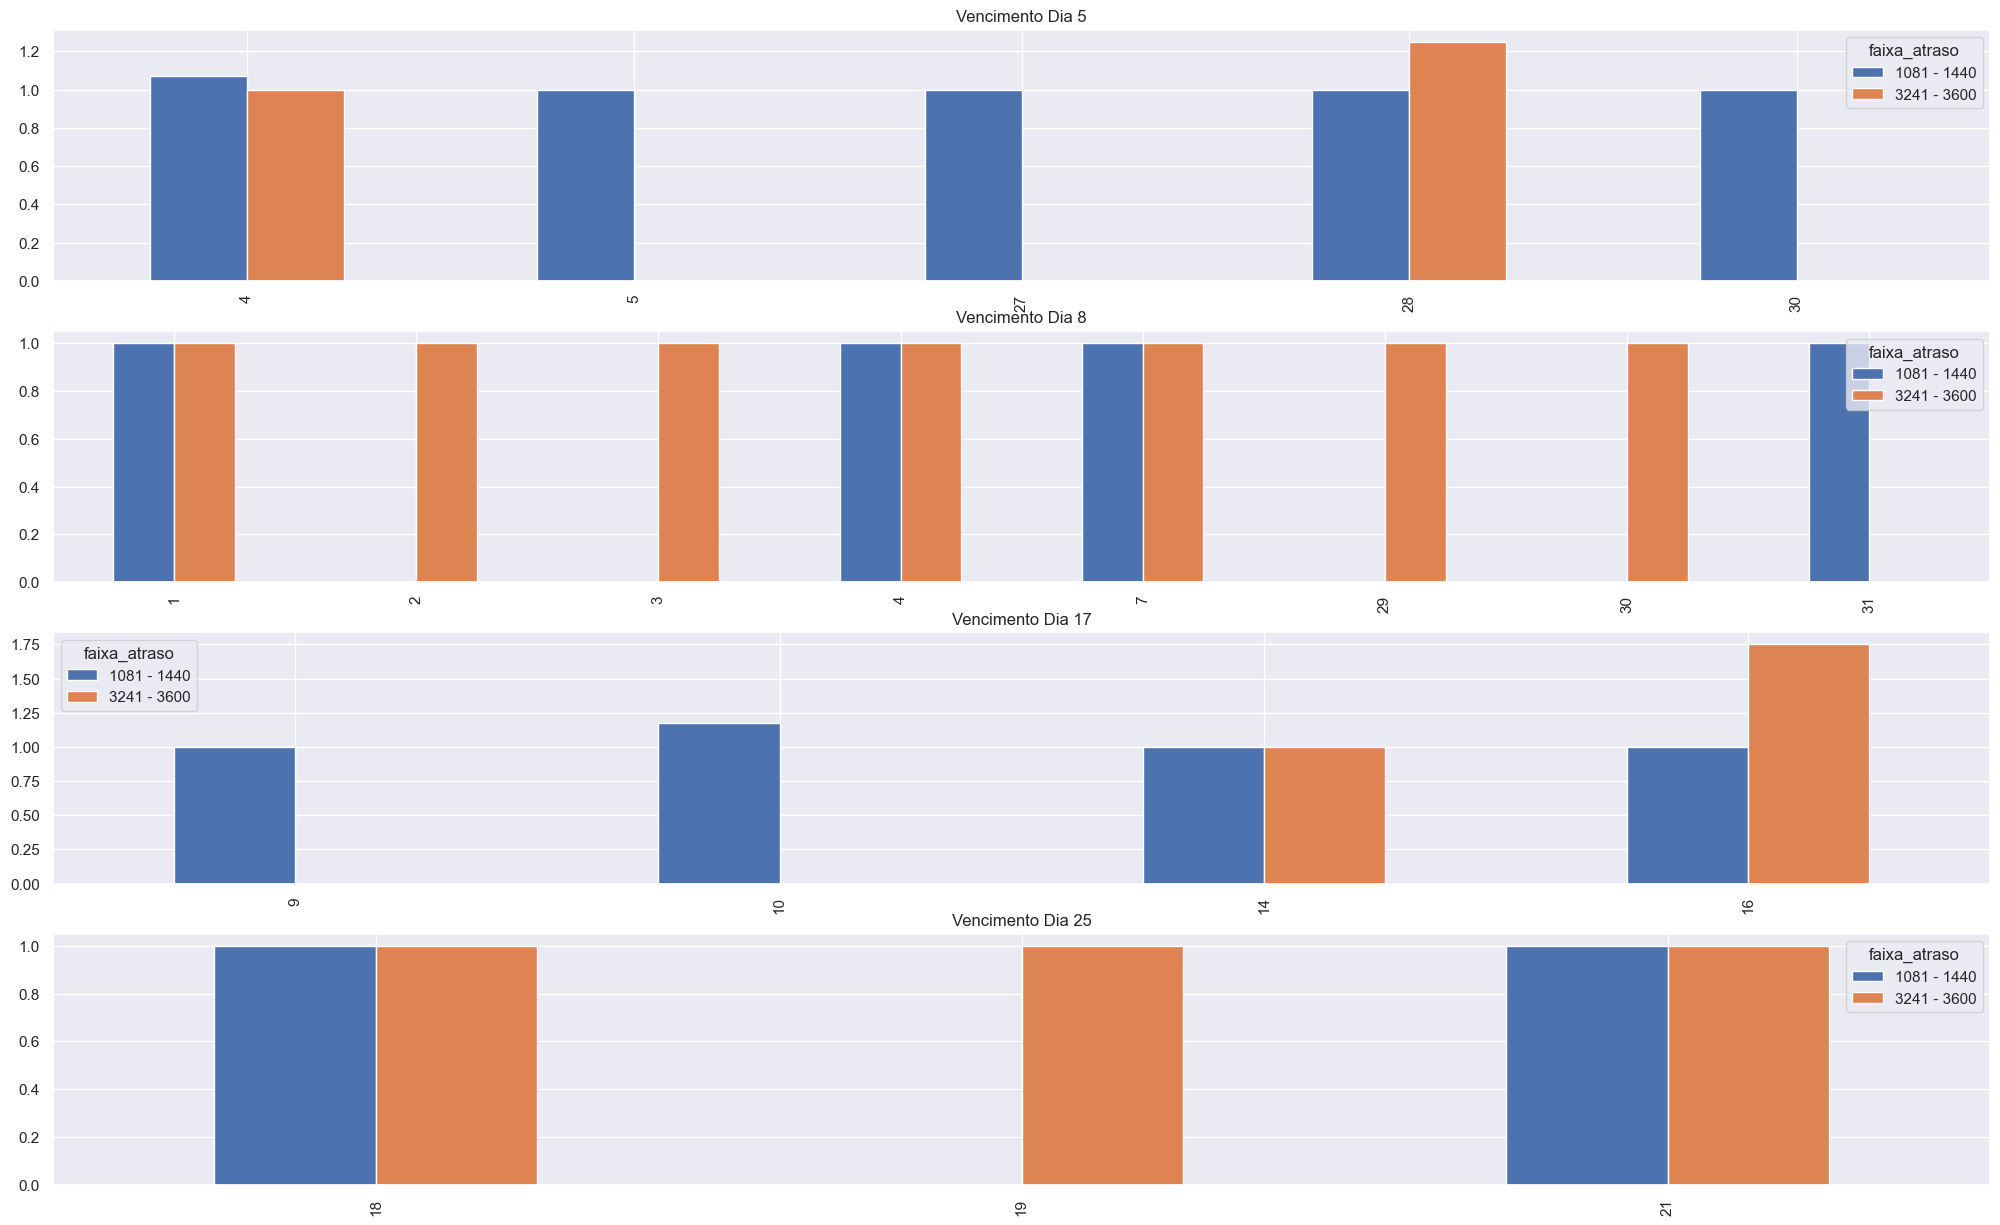

In [216]:
fig, axs = plt.subplots(4,1, figsize=(25,15))
producao_fa[producao_fa['dia_vencimento'] == 5]['count'].groupby(by=[producao_fa['dia_producao'],producao_fa['faixa_atraso']]).mean().unstack().fillna(0).plot(kind='bar', ax= axs[0], title='Vencimento Dia 5')
axs[0].set_xlabel('')
producao_fa[producao_fa['dia_vencimento'] == 8]['count'].groupby(by=[producao_fa['dia_producao'],producao_fa['faixa_atraso']]).mean().unstack().fillna(0).plot(kind='bar', ax= axs[1], title='Vencimento Dia 8')
axs[1].set_xlabel('')
producao_fa[producao_fa['dia_vencimento'] == 17]['count'].groupby(by=[producao_fa['dia_producao'],producao_fa['faixa_atraso']]).mean().unstack().fillna(0).plot(kind='bar', ax= axs[2], title='Vencimento Dia 17')
axs[2].set_xlabel('')
producao_fa[producao_fa['dia_vencimento'] == 25]['count'].groupby(by=[producao_fa['dia_producao'],producao_fa['faixa_atraso']]).mean().unstack().fillna(0).plot(kind='bar', ax= axs[3], title='Vencimento Dia 25')
axs[3].set_xlabel('')

Aqui é possível observar que os clientes tem tendência a fechar proposta uma semana antes da data de vencimento. O segundo melhor dia de produção é o dia anterior ao vencimento. 

Para depois do almoço 

- Abrir por faixas
- Ver a relação dos dias com maior taxa de pagamento que dia que foi feito a proposta

Após essas análises verificar 

- Regressão para entender quais variaveis que mais impactam  na taxa de atraso